<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

import missingno as msno
from fancyimpute import MICE

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import r2_score, classification_report
from sklearn.metrics import precision_recall_fscore_support, f1_score
from sklearn.metrics import confusion_matrix, roc_curve, auc

from sklearn.ensemble import RandomForestClassifier

from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE, RFECV

from functools import reduce

from sklearn.linear_model import SGDRegressor, SGDClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.cross_validation import KFold, train_test_split
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler, NearMiss, CondensedNearestNeighbour
from imblearn.under_sampling import EditedNearestNeighbours, RepeatedEditedNearestNeighbours, TomekLinks
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.combine import SMOTEENN, SMOTETomek

from pprint import pprint
sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

/Users/jasminetan/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/Users/jasminetan/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

# 1.1. DATA CLEANING

In [2]:
# Load the data:
house_df = pd.read_csv('./housing.csv')

# Examine number of rows and columns:
house_df.shape

(1460, 81)

In [3]:
# Inspect extract of data:
pd.set_option('max_columns', 100) # Show all columns
house_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### 1.1.a REDUCE DIMENSIONS BY DROPPING IRRELEVANT/UNNECESSARY COLUMNS/ROWS

In [4]:
# Remove "Id" as rows already have index:
house_df = house_df.drop(columns=["Id"])

# Drop duplicates rows, if any:
house_df = house_df.drop_duplicates()

# Remove non-residential rows - For "MSZoning", drop all non-residential rows ("C"):
# "FV" represents Floating Village Residential, which is also a residential level
house_df = house_df.loc[house_df["MSZoning"] != "C (all)", :]

# Examine column values (null values and data types):
house_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1450 entries, 0 to 1459
Data columns (total 80 columns):
MSSubClass       1450 non-null int64
MSZoning         1450 non-null object
LotFrontage      1191 non-null float64
LotArea          1450 non-null int64
Street           1450 non-null object
Alley            89 non-null object
LotShape         1450 non-null object
LandContour      1450 non-null object
Utilities        1450 non-null object
LotConfig        1450 non-null object
LandSlope        1450 non-null object
Neighborhood     1450 non-null object
Condition1       1450 non-null object
Condition2       1450 non-null object
BldgType         1450 non-null object
HouseStyle       1450 non-null object
OverallQual      1450 non-null int64
OverallCond      1450 non-null int64
YearBuilt        1450 non-null int64
YearRemodAdd     1450 non-null int64
RoofStyle        1450 non-null object
RoofMatl         1450 non-null object
Exterior1st      1450 non-null object
Exterior2nd      1450 non-

### 1.1.b HANDLING NULL VALUES

In [5]:
# Get the names of columns with null values:
columns_has_null = [column_name for column_name in house_df.columns.values if house_df[column_name].isnull().values.any()]
columns_has_null

['LotFrontage',
 'Alley',
 'MasVnrType',
 'MasVnrArea',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Electrical',
 'FireplaceQu',
 'GarageType',
 'GarageYrBlt',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PoolQC',
 'Fence',
 'MiscFeature']

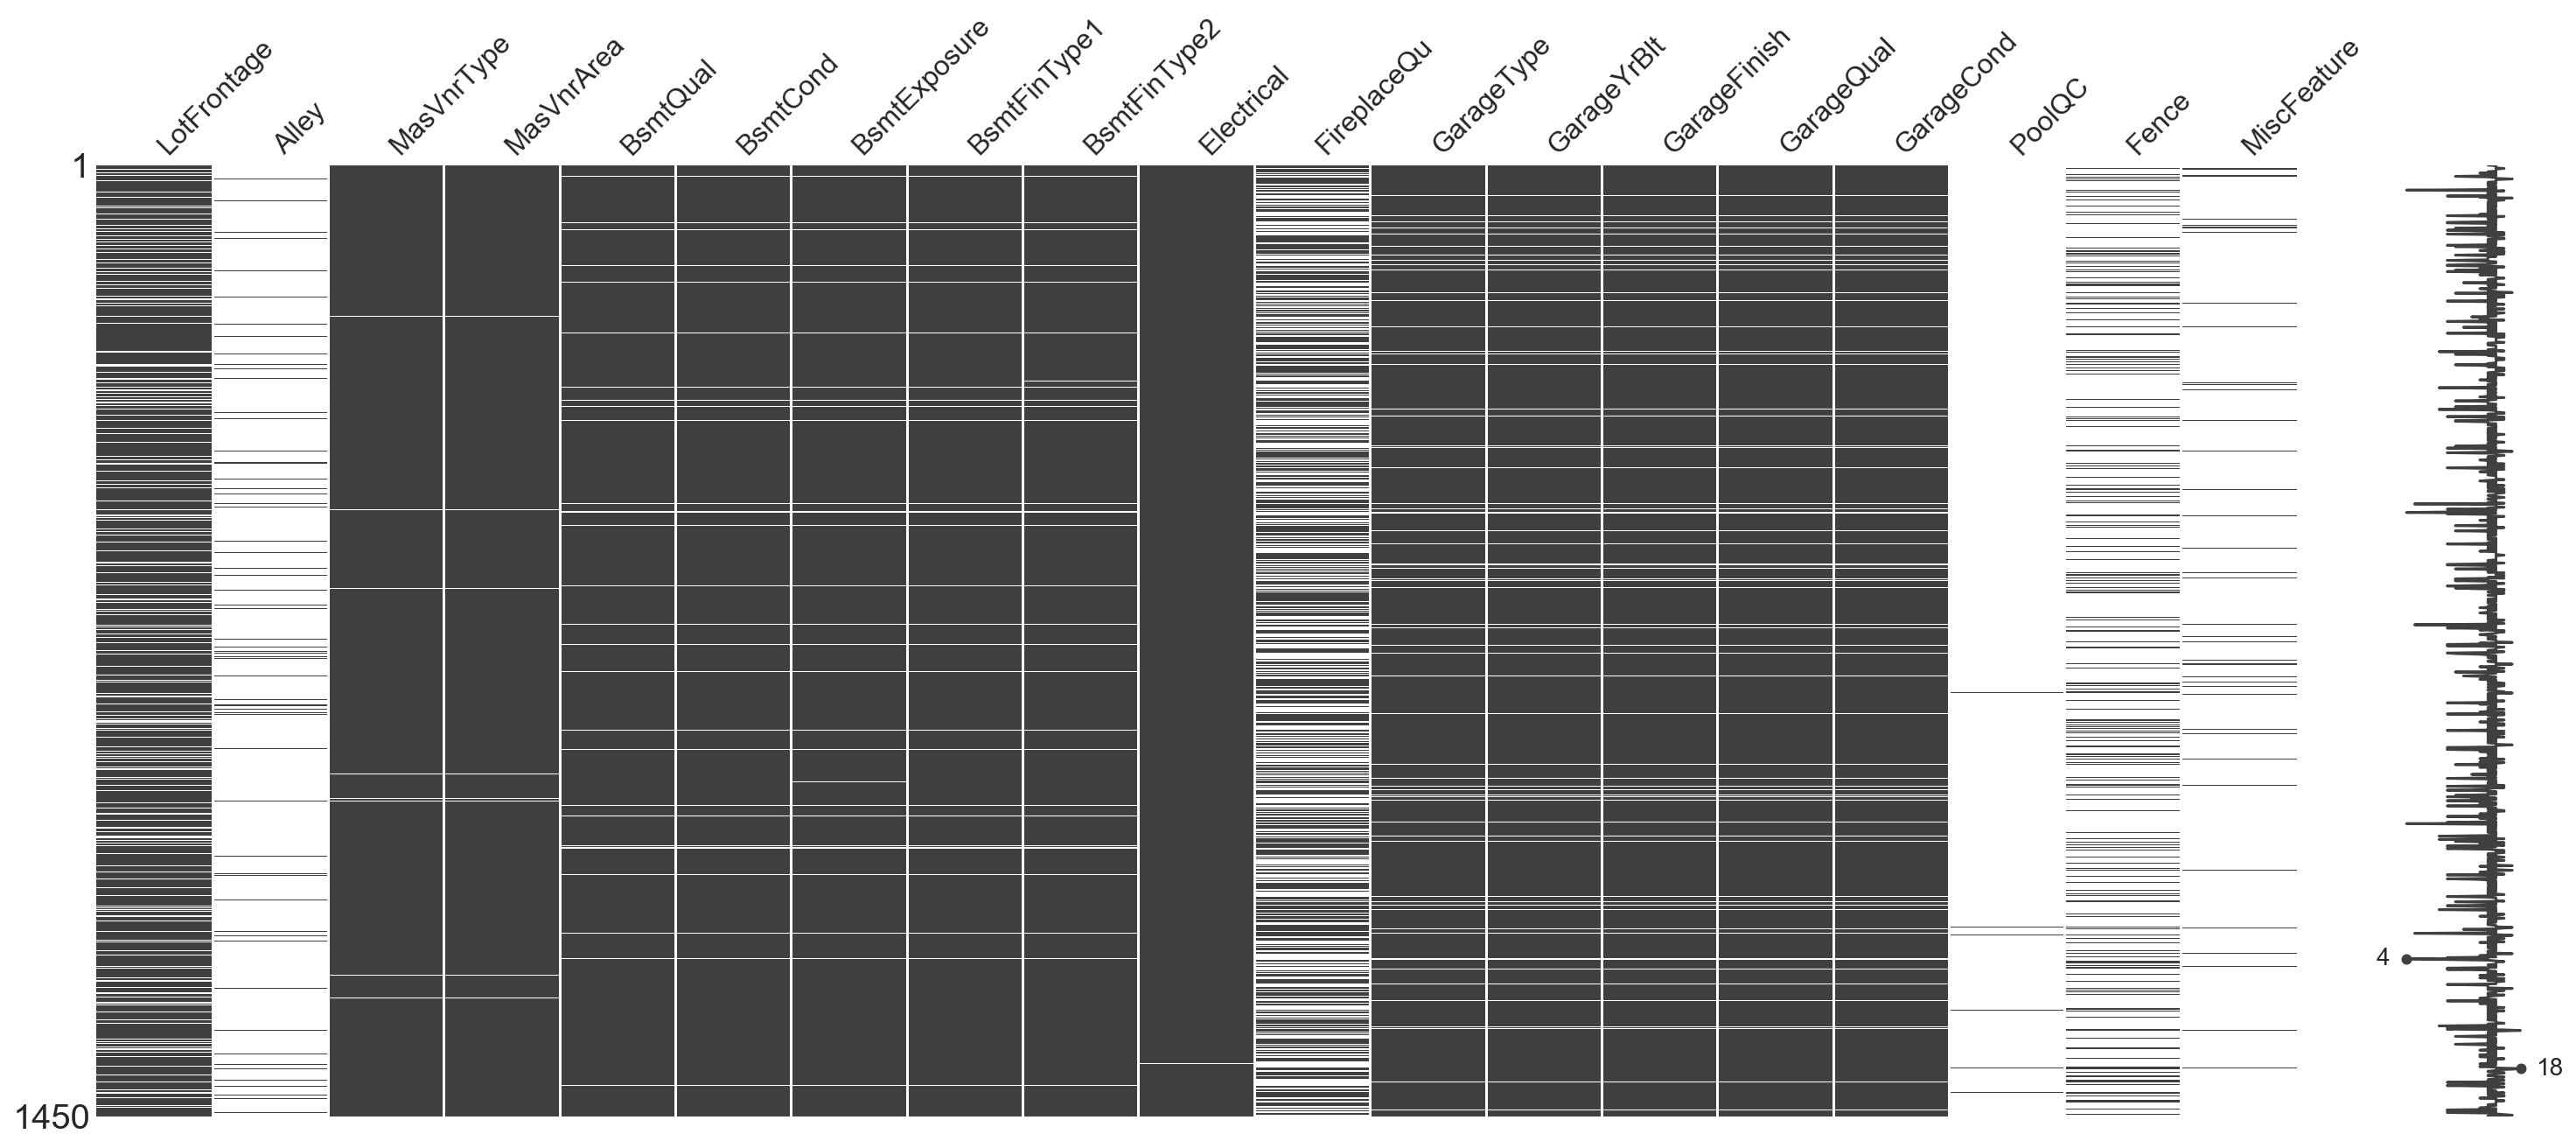

In [6]:
# Plot nullity matrix showing patterns in the missing data and general shape of data completeness:
msno.matrix(house_df[columns_has_null])
plt.show()

# "MasVnrType" and "MasVnrArea" have null values in the same rows
# "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2" have null values in the same rows
# "BsmtExposure" has one extra null value though
# "GarageType", "GarageYrBlt", "GarageFinish", "GarageQual" and "GarageCond" have null values in the same rows
# "Alley", "FireplaceQu", "PoolQC", "Fence" and "MiscFeature" are majority null -- Do nulls represent a value?
# "Electrical" has very few -- only one? -- null values

### What do the columns with missing data represent?
Do null values mean something?

- 'LotFrontage': Linear feet of street connected to property
    
- 'Alley': Type of alley access to property
    - Null values mean "NA" -- there is no alley access: Replace with "None" string
    
- 'MasVnrType': Masonry veneer type
    - Null values mean "None" -- there is no masonry veneer: Replace with "None" string
    
- 'MasVnrArea': Masonry veneer area in square feet
    - Null values mean "None" -- there is no masonry veneer (area is 0): Replace with 0
    
- 'BsmtQual': Height of the basement
    - Null values mean "No Basement": Replace with "None" string
    
- 'BsmtCond': General condition of the basement
    - Null values mean "No Basement": Replace with "None" string
    
- 'BsmtExposure': Walkout or garden level basement walls
    - Null values mean "No Basement": Replace with "None" string
    
- 'BsmtFinType1': Type 1 finished square feet
    - Null values mean "No Basement": Replace with "None" string
    
- 'BsmtFinType2': Type 2 finished square feet
    - Null values mean "No Basement": Replace with "None" string
    
- 'Electrical': Electrical system

- 'FireplaceQu': Fireplace quality
    - Null values mean "No Fireplace": Replace with "None" string
    
- 'GarageType': Garage location
    - Null values mean "No Garage": Replace with "None" string

- 'GarageYrBlt': Year garage was built
    - Null values mean "No Garage": Replace with "None" string
    
- 'GarageFinish': Interior finish of the garage
    - Null values mean "No Garage": Replace with "None" string
    
- 'GarageQual': Garage quality
    - Null values mean "No Garage": Replace with "None" string
        
- 'GarageCond': Garage condition
    - Null values mean "No Garage": Replace with "None" string
    
- 'PoolQC': Pool quality
    - Null values mean "No Pool": Replace with "None" string
    
- 'Fence': Fence quality
    - Null values mean "No Fence": Replace with "None" string
    
- 'MiscFeature':
    - Null values mean "NA": Replace with "None" string
    
Summary: 
- Replace all null values in all columns except "LotFrontage" and "Electrical" with the string "None"
- Investigate deeper into nature of missing data in "LotFrontage" and "Electrical"

In [7]:
# Inspect the row where "BsmtExposure" is null but the other basement features are not:
house_df[house_df["BsmtExposure"].isnull() & house_df["BsmtQual"].notnull()]

# Null value probably refers to "No", meaning "No Exposure" -- but seems to be only such value so drop row:
index_to_drop = house_df[house_df["BsmtExposure"].isnull() & house_df["BsmtQual"].notnull()].index.values
house_df = house_df.drop(index=index_to_drop)

# Check number of rows should be 1449:
assert house_df.shape[0] == 1449

In [8]:
# Replace all null values in all columns except "LotFrontage", "Electrical", "MasVnrArea" with the string "None"
columns_has_null.remove("LotFrontage")
columns_has_null.remove("Electrical")
columns_has_null.remove("MasVnrArea")
house_df[columns_has_null] = house_df[columns_has_null].fillna(value="None")

# Replace null values in "MasVnrArea" with 0:
house_df["MasVnrArea"] = house_df["MasVnrArea"].fillna(value=0)

In [9]:
# Inspect that one null value in "Electrical":
house_df[house_df["Electrical"].isnull()]

# Can't infer what the null value represents -- Drop that row:
house_df = house_df.drop(index=house_df[house_df["Electrical"].isnull()].index.values)

# Check number of rows should be 1448:
assert house_df.shape[0] == 1448

In [10]:
# Examine values of "LotFrontage":
house_df["LotFrontage"].unique()

# Doesn't seem like the null values represent a linear feet of 0

array([ 65.,  80.,  68.,  60.,  84.,  85.,  75.,  nan,  51.,  50.,  70.,
        91.,  72.,  66., 101.,  57.,  44., 110.,  98.,  47., 108., 112.,
        74., 115.,  61.,  48.,  33.,  52., 100.,  24.,  89.,  63.,  76.,
        81.,  95.,  69.,  21.,  32.,  78., 121., 122.,  40.,  73.,  77.,
        64.,  94., 105.,  34.,  90.,  55.,  88.,  82.,  71., 120., 107.,
        92., 134.,  62.,  86., 141.,  97.,  54.,  41.,  79., 174.,  99.,
        67.,  83.,  43., 103.,  93.,  30., 129., 140.,  35.,  37., 118.,
        87., 116., 150., 111.,  49.,  96.,  59.,  36.,  56., 102.,  58.,
        38., 109., 130.,  53., 137.,  45., 106., 104.,  42.,  39., 144.,
       114., 128., 149., 313., 168., 182., 138., 160., 152., 124., 153.,
        46.])

In [11]:
house_df.loc[house_df["LotFrontage"].isnull(), ["LotFrontage", "LotArea", "LotShape"]].head(20)

# Doesn't seem like the column values are related to any particular "LotArea" or "LotShape" -- Is data missing (completely) at random?
# Too many null values for case deletion

,LotFrontage,LotArea,LotShape
7,NaN,10382,IR1
12,NaN,12968,IR2
14,NaN,10920,IR1
16,NaN,11241,IR1
24,NaN,8246,IR1
31,NaN,8544,IR1
42,NaN,9180,IR1
43,NaN,9200,IR1
50,NaN,13869,IR2
64,NaN,9375,Reg


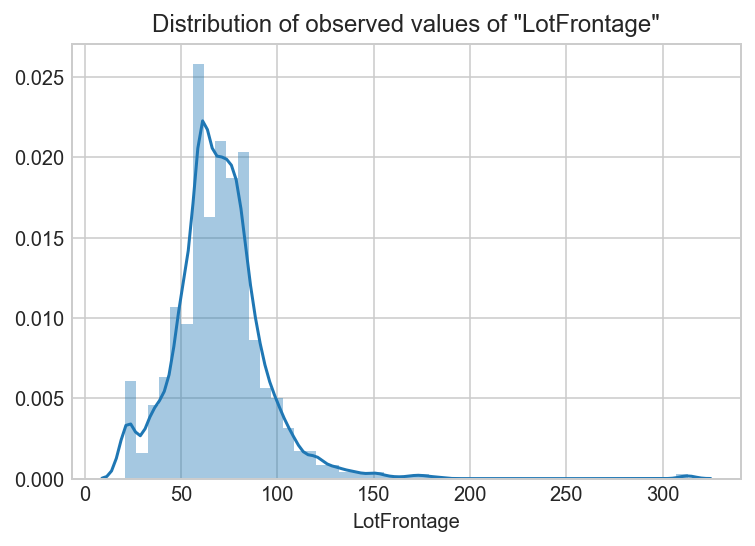

In [12]:
# Examine distribution of observed values of "LotFrontage" to see if imputation by average is appropriate:
lotfrontage_non_null = house_df.loc[house_df["LotFrontage"].notnull(), "LotFrontage"]
sns.distplot(lotfrontage_non_null)
plt.title("Distribution of observed values of \"LotFrontage\"")
plt.show()

# Distribution is unimodal, but not symmetric (skewed right), and variance seem not small
# Use more predictive techniques for imputation?

In [13]:
# Try out Multiple Imputation using MICE from "fancyimpute" package:
house_df["LotFrontage"] = MICE().complete(house_df[["LotFrontage"]])

# Could also try: 
# - KNN imputation
# - Imputation based on possible correlation of "LotFrontage" with "LotArea" 
# but MICE seems to be an efficient method

[MICE] Completing matrix with shape (1448, 1)
[MICE] Starting imputation round 1/110, elapsed time 0.001
[MICE] Starting imputation round 2/110, elapsed time 0.050
[MICE] Starting imputation round 3/110, elapsed time 0.050
[MICE] Starting imputation round 4/110, elapsed time 0.051
[MICE] Starting imputation round 5/110, elapsed time 0.056
[MICE] Starting imputation round 6/110, elapsed time 0.057
[MICE] Starting imputation round 7/110, elapsed time 0.057
[MICE] Starting imputation round 8/110, elapsed time 0.058
[MICE] Starting imputation round 9/110, elapsed time 0.058
[MICE] Starting imputation round 10/110, elapsed time 0.066
[MICE] Starting imputation round 11/110, elapsed time 0.067
[MICE] Starting imputation round 12/110, elapsed time 0.067
[MICE] Starting imputation round 13/110, elapsed time 0.068
[MICE] Starting imputation round 14/110, elapsed time 0.069
[MICE] Starting imputation round 15/110, elapsed time 0.070
[MICE] Starting imputation round 16/110, elapsed time 0.072
[MI

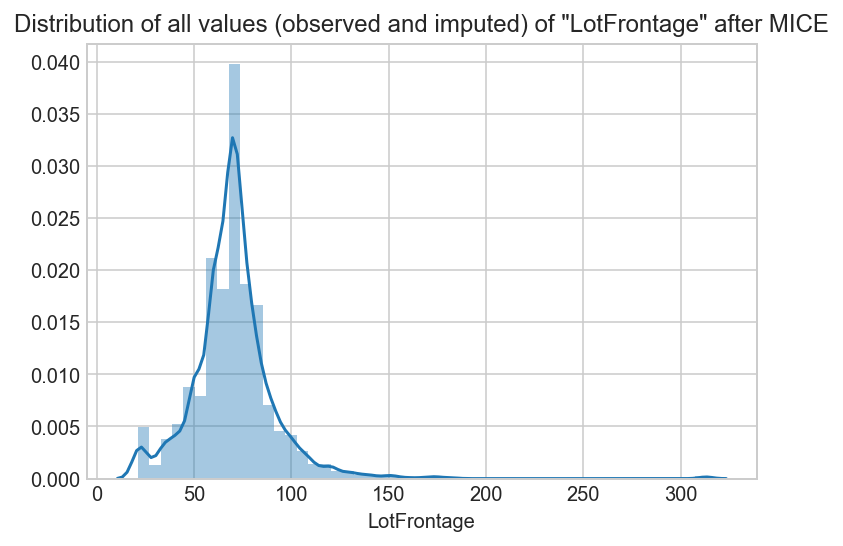

In [14]:
# Visualize distribution of all "LotFrontage" values:
sns.distplot(house_df["LotFrontage"])
plt.title("Distribution of all values (observed and imputed) of \"LotFrontage\" after MICE")
plt.show()

In [15]:
# Check that no more null values:
columns_has_null_after = [column_name for column_name in house_df.columns.values if house_df[column_name].isnull().values.any()]
assert len(columns_has_null_after) == 0

### 1.1.c ADDRESSING OUTLIERS

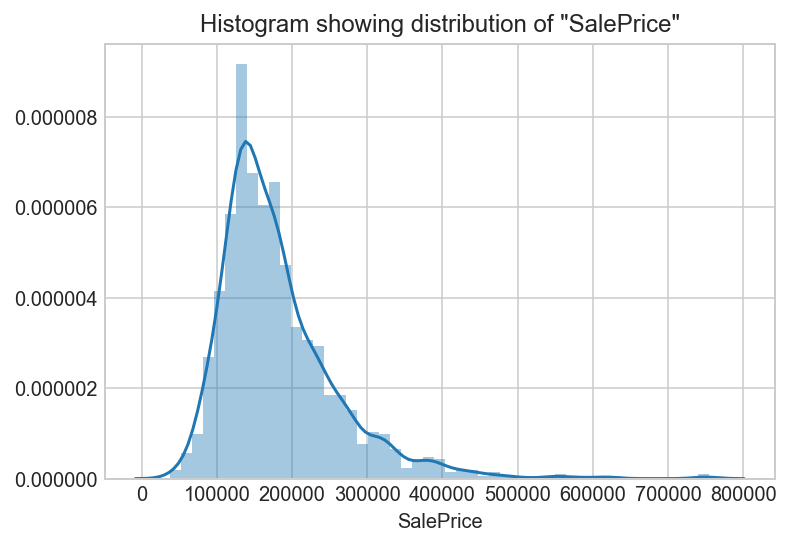

In [16]:
# Visualize distribution of "SalePrice":
sns.distplot(house_df["SalePrice"])
plt.title("Histogram showing distribution of \"SalePrice\"")
plt.show()

# Data is unimodal, non-symmetric (skewed right/positive) -- Mean > Median > Mode
# Outliers represent houses that sold for an extremely high price (relative to others)

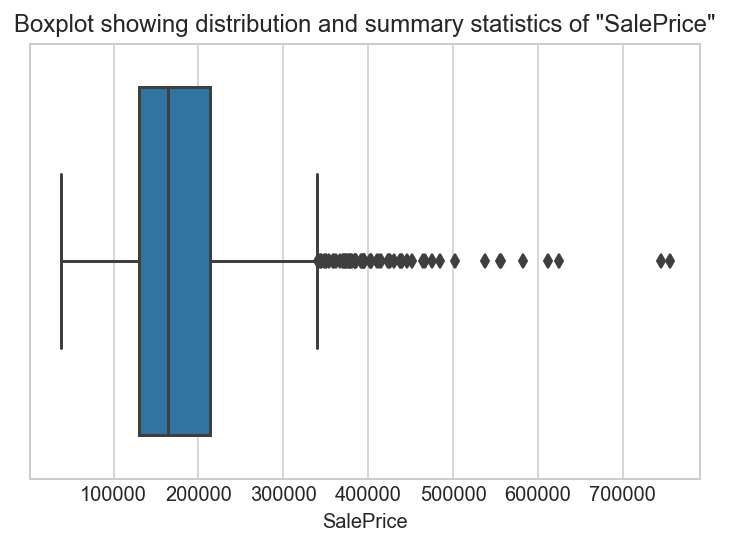

In [17]:
# Plot boxplot of "SalePrice":
sns.boxplot(house_df["SalePrice"])
plt.title("Boxplot showing distribution and summary statistics of \"SalePrice\"")
plt.show()

# Many outliers -- But given sparsity of observations (only 1393 rows), will keep outliers.

### 1.1.d EXAMINING/EDITING OF CATEGORICAL DATA

In [18]:
# Numerical data that's actually categorical:
# - MSSubClass
# - YearBuilt 
# - YearRemodAdd
# - MoSold
# - YrSold
# But don't include the month/year categories

# Since "OverallQual" and "OverallCond" are scales with more than 5 levels, just assume/take it as continuous/numerical

categorical_columns = ["MSSubClass"]

# Convert these columns' dtypes to 'object':
house_df[categorical_columns] = house_df[categorical_columns].astype('object')

In [19]:
for column_name in house_df.columns.values:
    if house_df[column_name].dtypes == object or column_name in categorical_columns:
        print(house_df[column_name].value_counts())
        print("***")
        if column_name not in categorical_columns:
            categorical_columns.append(column_name)

# For X, y split:
# Only consider fixed (Part 1) and renovatable (Part 2) characteristics (ignore "SaleType", "SaleCondition")

# For eature engineering:
# Convert "YearBuilt", "YearRemodAdd", "YrSold", "GarageYrBlt" to "HouseAge", "YrsSinceRemod", "GarageAge"

# **Consider combine levels having frequency less than 1% of total observation (15 counts or less)

# Drop "Street" since only 6 values are "Gravl" (rest are "Pave")
# For "LotShape", combine "IR2" and "IR3" values to "IR2"
# Drop "Utilities" since only one value is "NoSeWA" (all other values are "AllPub")
# For "LotConfig", combine "FR2" and "FR3" values to "FR"
# For "LandSlope", combine "Mod" and "Sev" values to "Mod"
# For "Neighborhood", combine "Veenker", "NPkVill", "Blueste" to "Other"
# For "Condition1" and "Condition2", merge "PosN" and "PosA"; "RRAe" and "RRNe"; "RRAn" and "RRAe"
# For "HouseStyle", merge "1.5Fin" and "1.5Unf"; "2.5Unf" and "2.5Fin"
# For "RoofStyle", merge "Flat", "Gambrel", "Mansard" and "Shed" to "Other"
# Drop "RoofMatl" since vast majorit (>98%) are "CompShg"
# Change "CmentBd" in "Exterior2nd" column to "CemntBd"; "Wd Shng" to "WdShing"; "Brk Cmn" to "BrkComm"
# For "Exterior1st" and "Exterior2nd", merge "Stone", "BrkComm", "AsphShn", "ImStucc", "CBlock" to "Others"
# Change "BrkCmn" in "MasVnrType" to "BrkComm" -- just to standardize
# For "ExterCond", merge "Fa" and "Po" to "Fa"
# For "Foundation", merge "Slab", Stone" and "Wood" to "Other"
# For "BsmtCond", merge "Fa" and "Po" to "Fa"
# For "Heating", merge "Grav", "Wall", "OthW" and "Floor" to "Other"
# For "HearingQC", merge "Fa" and "Po" to "Fa"
# For "CentralAir", convert "Y" to 1 and "N" to 0
# For "Electrical", merge "FuseF", "FuseP" and "Mix" to "FuseF"
# For "Functional", merge "Maj1", "Maj2", "Sev" to "Maj"
# Do we need"GarageYrBlt" if we have "YearBuilt" and "YearRemodAdd"?
# For "GarageQual", merge "Po" and "Fa" to "Fa"; "Gd" and "Ex" to "Gd"
# For "GarageCond", merge "Po" and "Fa" to "Fa"; "Gd" and "Ex" to "Gd"
# Drop "PoolQC" since majority (>99.5%) are "None"
# For "MiscFeature", only keep "Shed" -- rename feature as "HasShed"

# Should I convert certain ordinal categorical data to numerical? 
# "ExterQual",
# "ExterCond",
# "BsmtQual",
# "BsmtCond",
# "HeatingQC",
# "KitchenQual",
# "FireplaceQu",
# "GarageQual",
# "GarageQual"

# "GarageFinish"
# "Functional"
# "BsmtExposure"
# But apparently one should only treat scales with more than 5 (some sources say 11) categories as continuous

20     534
60     298
50     140
120     87
30      67
160     63
70      59
80      57
90      52
190     29
85      20
75      16
45      12
180     10
40       4
Name: MSSubClass, dtype: int64
***
RL    1149
RM     218
FV      65
RH      16
Name: MSZoning, dtype: int64
***
Pave    1444
Grvl       4
Name: Street, dtype: int64
***
None    1359
Grvl      50
Pave      39
Name: Alley, dtype: int64
***
Reg    915
IR1    482
IR2     41
IR3     10
Name: LotShape, dtype: int64
***
Lvl    1303
Bnk      62
HLS      49
Low      34
Name: LandContour, dtype: int64
***
AllPub    1447
NoSeWa       1
Name: Utilities, dtype: int64
***
Inside     1042
Corner      261
CulDSac      94
FR2          47
FR3           4
Name: LotConfig, dtype: int64
***
Gtl    1373
Mod      62
Sev      13
Name: LandSlope, dtype: int64
***
NAmes      225
CollgCr    149
OldTown    112
Edwards    100
Somerst     86
Gilbert     79
NridgHt     77
Sawyer      74
NWAmes      73
SawyerW     59
BrkSide     58
Crawfor     51
Mitchel 

In [20]:
# Drop "Street", "Utilities", "RoofMatl", "PoolQC" features:
house_df = house_df.drop(columns=["Street", "Utilities", "RoofMatl", "PoolQC"])

# Change "CmentBd" in "Exterior2nd" column to "CemntBd"; "Wd Shng" to "WdShing"; "Brk Cmn" to "BrkComm"
house_df.loc[house_df["Exterior2nd"] == "CmentBd", "Exterior2nd"] = "CemntBd"
house_df.loc[house_df["Exterior2nd"] == "Wd Shng", "Exterior2nd"] = "WdShing"
house_df.loc[house_df["Exterior2nd"] == "Brk Cmn", "Exterior2nd"] = "BrkComm"
print(house_df["Exterior2nd"].value_counts())
print("***")

# Change "BrkCmn" in "MasVnrType" to "BrkComm" -- just to standardize
house_df.loc[house_df["MasVnrType"] == "BrkCmn", "MasVnrType"] = "BrkComm"
print(house_df["MasVnrType"].value_counts())
print("***")

VinylSd    502
MetalSd    209
HdBoard    207
Wd Sdng    195
Plywood    141
CemntBd     60
WdShing     38
Stucco      26
BrkFace     24
AsbShng     19
ImStucc     10
BrkComm      7
Stone        5
AsphShn      3
Other        1
CBlock       1
Name: Exterior2nd, dtype: int64
***
None       861
BrkFace    444
Stone      128
BrkComm     15
Name: MasVnrType, dtype: int64
***


In [21]:
# Add feature "Has2Exteriors" if more than one material -- in order to merge "Exterior1st" and "Exterior2nd" later on:
house_df["Has2Exteriors"] = 1
house_df.loc[house_df["Exterior1st"] == house_df["Exterior2nd"], "Has2Exteriors"] = 0

# Check
house_df[["Exterior1st", "Exterior2nd", "Has2Exteriors"]].head()

,Exterior1st,Exterior2nd,Has2Exteriors
0,VinylSd,VinylSd,0
1,MetalSd,MetalSd,0
2,VinylSd,VinylSd,0
3,Wd Sdng,WdShing,1
4,VinylSd,VinylSd,0


In [22]:
# Define function for combining values in a column to a certain value (i.e. replace certain values to another)"
def combine_feature_levels(feature_str, levels_before_ary, level_after_str, check_frequency=True):
    house_df.loc[house_df[feature_str].isin(levels_before_ary), feature_str] = level_after_str
    if check_frequency:
        print(house_df[feature_str].value_counts()) # Check frequency
        print("***")
    
# Create list of tuples in the format (feature_str, levels_before_ary, level_after_str) for features to change:
features_to_combine = [
    ("LotShape", ["IR3"], "IR2"), 
    ("LotConfig", ["FR2", "FR3"], "FR"), 
    ("LandSlope", ["Sev"], "Mod"), 
    ("Neighborhood", ["Veenker", "NPkVill", "Blueste"], "Other"), 
    ("Condition1", ["PosN", "PosA"], "Pos", False),
    ("Condition1", ["RRAe", "RRNe"], "RRe", False),
    ("Condition1", ["RRAn", "RRNn"], "RRn"),
    ("Condition2", ["PosN", "PosA"], "Pos", False),
    ("Condition2", ["RRAe", "RRNe"], "RRe", False),
    ("Condition2", ["RRAn", "RRNn"], "RRn"),
    ("HouseStyle", ["1.5Fin", "1.5Unf"], "1.5Story", False),
    ("HouseStyle", ["2.5Unf", "2.5Fin"], "2.5Story"),
    ("RoofStyle", ["Flat", "Gambrel", "Mansard", "Shed"], "Other"),
    ("Exterior1st", ["Stone", "BrkComm", "AsphShn", "ImStucc", "CBlock"], "Other"),
    ("Exterior2nd", ["Stone", "BrkComm", "AsphShn", "ImStucc", "CBlock"], "Other"),
    ("ExterCond", ["Po"], "Fa", False),
    ("ExterCond", ["Ex"], "Gd"),
    ("Foundation", ["Slab", "Stone", "Wood"], "Other"),
    ("BsmtCond", ["Po"], "Fa"),
    ("Heating", ["Grav", "Wall", "OthW", "Floor"], "Other"),
    ("HeatingQC", ["Po"], "Fa"),    
    ("CentralAir", ["Y"], 1, False),
    ("CentralAir", ["N"], 0),
    ("Electrical", ["FuseF", "FuseP", "Mix"], "FuseF"),
    ("Functional", ["Maj1", "Maj2", "Sev"], "Maj"),
    ("GarageQual", ["Po"], "Fa", False),
    ("GarageQual", ["Ex"], "Gd"),
    ("GarageCond", ["Po"], "Fa", False),
    ("GarageCond", ["Ex"], "Gd")
]

for each_feature in features_to_combine:
    try:
        combine_feature_levels(each_feature[0], each_feature[1], each_feature[2], each_feature[3])
    except:
        combine_feature_levels(each_feature[0], each_feature[1], each_feature[2])

Reg    915
IR1    482
IR2     51
Name: LotShape, dtype: int64
***
Inside     1042
Corner      261
CulDSac      94
FR           51
Name: LotConfig, dtype: int64
***
Gtl    1373
Mod      75
Name: LandSlope, dtype: int64
***
NAmes      225
CollgCr    149
OldTown    112
Edwards    100
Somerst     86
Gilbert     79
NridgHt     77
Sawyer      74
NWAmes      73
SawyerW     59
BrkSide     58
Crawfor     51
Mitchel     49
NoRidge     41
Timber      37
ClearCr     28
IDOTRR      28
SWISU       25
StoneBr     25
Other       22
MeadowV     17
Blmngtn     17
BrDale      16
Name: Neighborhood, dtype: int64
***
Norm      1250
Feedr       79
Artery      48
RRn         31
Pos         27
RRe         13
Name: Condition1, dtype: int64
***
Norm      1434
Feedr        5
Pos          3
RRn          3
Artery       2
RRe          1
Name: Condition2, dtype: int64
***
1Story      722
2Story      443
1.5Story    164
SLvl         64
SFoyer       37
2.5Story     18
Name: HouseStyle, dtype: int64
***
Gable    1133
H

In [23]:
# For "MiscFeature", only keep "Shed" -- rename feature as "HasShed"
house_df.loc[house_df["MiscFeature"] == "Shed", "MiscFeature"] = 1
house_df.loc[house_df["MiscFeature"] != "Shed", "MiscFeature"] = 0
house_df = house_df.rename(columns={"MiscFeature": "HasShed"})
house_df["HasShed"].head()

0    0
1    0
2    0
3    0
4    0
Name: HasShed, dtype: int64

In [24]:
# Merge "Condition1" and "Condition2"; "BsmtFinType1" and "BsmtFinType2"; "Exterior1st" and "Exterior2nd":
# - Manually dummy code variables
# - Add summary feature indicating number of levels "fulfilled"
# - Drop original columns

def create_merged_dummies(column_one_str, column_two_str, prefix_str, na_levels_ary):
    dummy_columns = []
    for each_level in house_df[column_one_str].unique():
        if each_level not in na_levels_ary:
            column_name = prefix_str + each_level
            dummy_columns.append(column_name)
            house_df[column_name] = 0
            house_df.loc[house_df[column_one_str] == each_level, column_name] = 1
            house_df.loc[house_df[column_two_str] == each_level, column_name] = 1
    house_df.drop(columns=[column_one_str, column_two_str], inplace=True)
    return dummy_columns

condition_dummies = create_merged_dummies("Condition1", "Condition2", "Condition_", ["Norm"])
house_df["NumConditions"] = house_df[condition_dummies].sum(axis="columns")

bsmt_dummies = create_merged_dummies('BsmtFinType1', 'BsmtFinType2', "BsmtFinType_", ["Unf", "None"])
house_df["NumFinBsmts"] = house_df[bsmt_dummies].sum(axis="columns")

exterior_dummies = create_merged_dummies("Exterior1st", "Exterior2nd", "Exterior_", ["Other"])

# Check:
house_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Alley,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,Fence,HasShed,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,Has2Exteriors,Condition_Feedr,Condition_Pos,Condition_Artery,Condition_RRe,Condition_RRn,NumConditions,BsmtFinType_GLQ,BsmtFinType_ALQ,BsmtFinType_Rec,BsmtFinType_BLQ,BsmtFinType_LwQ,NumFinBsmts,Exterior_VinylSd,Exterior_MetalSd,Exterior_Wd Sdng,Exterior_HdBoard,Exterior_BrkFace,Exterior_WdShing,Exterior_CemntBd,Exterior_Plywood,Exterior_AsbShng,Exterior_Stucco
0,60,RL,65.0,8450,None,Reg,Lvl,Inside,Gtl,CollgCr,1Fam,2Story,7,5,2003,2003,Gable,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,706,0,150,856,GasA,Ex,1,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,None,Attchd,2003,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,None,0,0,2,2008,WD,Normal,208500,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0
1,20,RL,80.0,9600,None,Reg,Lvl,FR,Gtl,Other,1Fam,1Story,6,8,1976,1976,Gable,None,0.0,TA,TA,CBlock,Gd,TA,Gd,978,0,284,1262,GasA,Ex,1,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,None,0,0,5,2007,WD,Normal,181500,0,1,0,0,0,0,1,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0
2,60,RL,68.0,11250,None,IR1,Lvl,Inside,Gtl,CollgCr,1Fam,2Story,7,5,2001,2002,Gable,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,486,0,434,920,GasA,Ex,1,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,None,0,0,9,2008,WD,Normal,223500,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0
3,70,RL,60.0,9550,None,IR1,Lvl,Corner,Gtl,Crawfor,1Fam,2Story,7,5,1915,1970,Gable,None,0.0,TA,TA,BrkTil,TA,Gd,No,216,0,540,756,GasA,Gd,1,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,None,0,0,2,2006,WD,Abnorml,140000,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0
4,60,RL,84.0,14260,None,IR1,Lvl,FR,Gtl,NoRidge,1Fam,2Story,8,5,2000,2000,Gable,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,655,0,490,1145,GasA,Ex,1,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,None,0,0,12,2008,WD,Normal,250000,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0


# 1.2 FEATURE ENGINEERING/DATA TRANSFORMATION

### 1.2.a FEATURE ADDITION/AGGREGATION/DECOMPOSITION

In [25]:
# Get summary statistics for current cleaned dataframe:
house_df.describe(include="all")

,MSSubClass,MSZoning,LotFrontage,LotArea,Alley,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,Fence,HasShed,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,Has2Exteriors,Condition_Feedr,Condition_Pos,Condition_Artery,Condition_RRe,Condition_RRn,NumConditions,BsmtFinType_GLQ,BsmtFinType_ALQ,BsmtFinType_Rec,BsmtFinType_BLQ,BsmtFinType_LwQ,NumFinBsmts,Exterior_VinylSd,Exterior_MetalSd,Exterior_Wd Sdng,Exterior_HdBoard,Exterior_BrkFace,Exterior_WdShing,Exterior_CemntBd,Exterior_Plywood,Exterior_AsbShng,Exterior_Stucco
count,1448.0,1448,1448.000000,1448.000000,1448,1448,1448,1448,1448,1448,1448,1448,1448.000000,1448.000000,1448.000000,1448.000000,1448,1448,1448.000000,1448,1448,1448,1448,1448,1448,1448.000000,1448.000000,1448.000000,1448.000000,1448,1448,1448.000000,1448,1448.000000,1448.000000,1448.000000,1448.000000,1448.000000,1448.000000,1448.000000,1448.000000,1448.000000,1448.000000,1448,1448.000000,1448,1448.000000,1448,1448,1448,1448,1448.000000,1448.000000,1448,1448,1448,1448.000000,1448.000000,1448.000000,1448.000000,1448.000000,1448.000000,1448,1448.0,1448.000000,1448.000000,1448.000000,1448,1448,1448.000000,1448.000000,1448.000000,1448.000000,1448.000000,1448.000000,1448.000000,1448.000000,1448.000000,1448.000000,1448.000000,1448.000000,1448.000000,1448.000000,1448.000000,1448.000000,1448.000000,1448.000000,1448.00000,1448.000000,1448.000000,1448.000000,1448.000000,1448.000000
unique,15.0,4,NaN,NaN,3,3,4,4,2,23,5,6,NaN,NaN,NaN,NaN,3,4,NaN,4,3,4,5,4,5,NaN,NaN,NaN,NaN,3,4,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,NaN,5,NaN,6,7,97,4,NaN,NaN,4,4,3,NaN,NaN,NaN,NaN,NaN,NaN,5,NaN,NaN,NaN,NaN,9,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,20.0,RL,NaN,NaN,None,Reg,Lvl,Inside,Gtl,NAmes,1Fam,1Story,NaN,NaN,NaN,NaN,Gable,None,NaN,TA,TA,PConc,TA,TA,No,NaN,NaN,NaN,NaN,GasA,Ex,NaN,SBrkr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TA,NaN,Typ,NaN,None,Attchd,None,Unf,NaN,NaN,TA,TA,Y,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,WD,Normal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,534.0,1149,NaN,NaN,1359,915,1303,1042,1373,225,1209,722,NaN,NaN,NaN,NaN,1133,861,NaN,898,1273,645,639,1301,946,NaN,NaN,NaN,NaN,1417,739,NaN,1327,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,727,NaN,1348,NaN,680,869,79,600,NaN,NaN,1301,1317,1333,NaN,NaN,NaN,NaN,NaN,NaN,1170,NaN,NaN,NaN,NaN,1259,1192,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,70.074044,10521.971685,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.114641,5.582873,1971.548343,1985.022790,NaN,NaN,103.872238,NaN,NaN,NaN,NaN,NaN,NaN,445.777624,46.935083,567.247928,1059.960635,NaN,NaN,0.938536,NaN,1165.214779,346.852210,5.538674,1517.605663,0.428177,0.057320,1.568370,0.383978,2.870166,1.046271,NaN,6.521409,NaN,0.616713,NaN,NaN,NaN,NaN,1.770028,473.328039,NaN,NaN,NaN,94.789365,46.535912,21.566298,3.437845,15.117403,2.781768,NaN,0.0,43.425414,6.316298,2007.813536,NaN,NaN,181657.227901,0.094613,0.058011,0.019337,0.033149,0.009669,0.023481,0.143646,0.298343,0.165055,0.127072,0.123619,0.082873,0.796961,0.355663,0.149862,0.154696,0.162983,0.03453,0.032459,0.042818,0.105663,0.015193,0.021409
std,NaN,NaN,22.064429,10018.662405,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.373299,1.107883,30.019144,20.553573,NaN,NaN,181.251629,NaN,NaN,NaN,NaN,NaN,NaN,456.368735,161.930868,442.758447,439.

In [26]:
# Features to add/aggregate:
# "HouseAge" = "YrSold" - "YearBuilt"
# "YrsSinceRemod" = "YrSold" - "YearRemodAdd"
# "TotalBaths" = "FullBath" + "HalfBath" + "BsmtFullBath" + "BsmtHalfBath" 
# "AvgRoomSize" = "GrLivArea" / "TotRmsAbvGrd"
# "BathToRoomRatio" = ("FullBath" + "HalfBath") / "TotRmsAbvGrd" 
# "RelativeLivingSize" = "GrLivArea" / mean("GrLivArea")
# (maybe) "GarageInteract" = "GarageQual" + "GarageCars" [4 * 5 = 20 combinations]
# (maybe) "LandscapeInteract" = "LotShape" + "LandContour" [3 * 4 = 12 combinations]

house_df["HouseAge"] = house_df["YrSold"] - house_df["YearBuilt"]
house_df["YrsSinceRemod"] = house_df["YrSold"] - house_df["YearRemodAdd"]
house_df["TotalBaths"] = house_df["FullBath"] + house_df["HalfBath"] + house_df["BsmtFullBath"] + house_df["BsmtHalfBath"]
house_df["AvgRoomSize"] = house_df["GrLivArea"] / house_df["TotRmsAbvGrd"]
house_df["BathToRoomRatio"] = (house_df["FullBath"] + house_df["HalfBath"]) / house_df["TotRmsAbvGrd"]
house_df["RelativeLivingSize"] = house_df["GrLivArea"] / house_df["GrLivArea"].mean()

house_df = house_df.drop(columns=["YearBuilt", "YearRemodAdd", "MoSold"])

# Check:
house_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Alley,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,BldgType,HouseStyle,OverallQual,OverallCond,RoofStyle,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,Fence,HasShed,MiscVal,YrSold,SaleType,SaleCondition,SalePrice,Has2Exteriors,Condition_Feedr,Condition_Pos,Condition_Artery,Condition_RRe,Condition_RRn,NumConditions,BsmtFinType_GLQ,BsmtFinType_ALQ,BsmtFinType_Rec,BsmtFinType_BLQ,BsmtFinType_LwQ,NumFinBsmts,Exterior_VinylSd,Exterior_MetalSd,Exterior_Wd Sdng,Exterior_HdBoard,Exterior_BrkFace,Exterior_WdShing,Exterior_CemntBd,Exterior_Plywood,Exterior_AsbShng,Exterior_Stucco,HouseAge,YrsSinceRemod,TotalBaths,AvgRoomSize,BathToRoomRatio,RelativeLivingSize
0,60,RL,65.0,8450,None,Reg,Lvl,Inside,Gtl,CollgCr,1Fam,2Story,7,5,Gable,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,706,0,150,856,GasA,Ex,1,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,None,Attchd,2003,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,None,0,0,2008,WD,Normal,208500,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,5,5,4,213.750000,0.375000,1.126775
1,20,RL,80.0,9600,None,Reg,Lvl,FR,Gtl,Other,1Fam,1Story,6,8,Gable,None,0.0,TA,TA,CBlock,Gd,TA,Gd,978,0,284,1262,GasA,Ex,1,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,None,0,0,2007,WD,Normal,181500,0,1,0,0,0,0,1,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,31,31,3,210.333333,0.333333,0.831573
2,60,RL,68.0,11250,None,IR1,Lvl,Inside,Gtl,CollgCr,1Fam,2Story,7,5,Gable,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,486,0,434,920,GasA,Ex,1,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,None,0,0,2008,WD,Normal,223500,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,7,6,4,297.666667,0.500000,1.176854
3,70,RL,60.0,9550,None,IR1,Lvl,Corner,Gtl,Crawfor,1Fam,2Story,7,5,Gable,None,0.0,TA,TA,BrkTil,TA,Gd,No,216,0,540,756,GasA,Gd,1,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,None,0,0,2006,WD,Abnorml,140000,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,91,36,2,245.285714,0.142857,1.131387
4,60,RL,84.0,14260,None,IR1,Lvl,FR,Gtl,NoRidge,1Fam,2Story,8,5,Gable,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,655,0,490,1145,GasA,Ex,1,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,None,0,0,2008,WD,Normal,250000,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,8,8,4,244.222222,0.333333,1.448334


### 1.2.b FEATURE REDUCTION

In [27]:
# Drop/Convert"GarageYrBlt" (arbitrary decision, mainly based on the fact that we already have "HouseAge")
house_df = house_df.drop(columns=["GarageYrBlt"])

### 1.2.c SEPARATION OF FIXED AND RENOVATABLE FEATURES

In [28]:
all_features = list(house_df.columns.values)

In [29]:
# Manually identify fixed features:
fixed_features = ['MSSubClass',
 'MSZoning',
 'LotFrontage',
 'LotArea',
 'Alley',
 'LotShape',
 'LandContour',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'BldgType',
 'HouseStyle',
 'Foundation',
 'BsmtQual',
 'BsmtExposure',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'FireplaceQu',
 'GarageType',
 'GarageCars',
 'GarageArea',
 'GarageQual',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'HasShed',
 'MiscVal',
 'Condition_Feedr',
 'Condition_Pos',
 'Condition_Artery',
 'Condition_RRe',
 'Condition_RRn',
 'NumConditions',
 'BsmtFinType_GLQ',
 'BsmtFinType_ALQ',
 'BsmtFinType_Rec',
 'BsmtFinType_BLQ',
 'BsmtFinType_LwQ',
 'NumFinBsmts',
 'HouseAge',
 'TotalBaths',
 'AvgRoomSize',
 'BathToRoomRatio',
 'RelativeLivingSize']

# Extract dataset with fixed features:
fixed_df = house_df[fixed_features]

### 1.2.d DUMMY CODING CATEGORICAL VARIABLES

In [30]:
# Get fixed categorical features:
fixed_cat_columns = [column_name for column_name in fixed_df.columns.values if fixed_df[column_name].dtypes == object]

In [31]:
# Select "None" and "Other" as reference categories (dummy variable to drop to have k-1 variables)
# Allows for easier interpretation:
# The regression coefficient gives you the difference in means between the category and the reference category
# e.g. If 'BsmtQual_Ex' has a positive coefficient of a certain magnitude, we can infer that having an excellent basement height/quality explains a higher sale price of that magnitude 
# This does NOT take interactions between dummy categories into account

drop_one_level_cats = []

for column_name in fixed_cat_columns:
    if "None" in fixed_df[column_name].values or "Other" in fixed_df[column_name].values:
        fixed_df.loc[fixed_df[column_name] == "None", column_name] = None
        fixed_df.loc[fixed_df[column_name] == "Other", column_name] = None
    else:
        drop_one_level_cats.append(column_name)
    fixed_df = pd.get_dummies(fixed_df, prefix=column_name, prefix_sep='_', columns=[column_name], sparse=False)

print(fixed_df.columns.values)
fixed_df.info()

['LotFrontage' 'LotArea' 'BsmtFinSF1' 'BsmtFinSF2' 'BsmtUnfSF'
 'TotalBsmtSF' '1stFlrSF' '2ndFlrSF' 'LowQualFinSF' 'GrLivArea'
 'BsmtFullBath' 'BsmtHalfBath' 'FullBath' 'HalfBath' 'BedroomAbvGr'
 'KitchenAbvGr' 'TotRmsAbvGrd' 'Fireplaces' 'GarageCars' 'GarageArea'
 'WoodDeckSF' 'OpenPorchSF' 'EnclosedPorch' '3SsnPorch' 'ScreenPorch'
 'PoolArea' 'HasShed' 'MiscVal' 'Condition_Feedr' 'Condition_Pos'
 'Condition_Artery' 'Condition_RRe' 'Condition_RRn' 'NumConditions'
 'BsmtFinType_GLQ' 'BsmtFinType_ALQ' 'BsmtFinType_Rec' 'BsmtFinType_BLQ'
 'BsmtFinType_LwQ' 'NumFinBsmts' 'HouseAge' 'TotalBaths' 'AvgRoomSize'
 'BathToRoomRatio' 'RelativeLivingSize' 'MSSubClass_20' 'MSSubClass_30'
 'MSSubClass_40' 'MSSubClass_45' 'MSSubClass_50' 'MSSubClass_60'
 'MSSubClass_70' 'MSSubClass_75' 'MSSubClass_80' 'MSSubClass_85'
 'MSSubClass_90' 'MSSubClass_120' 'MSSubClass_160' 'MSSubClass_180'
 'MSSubClass_190' 'MSZoning_FV' 'MSZoning_RH' 'MSZoning_RL' 'MSZoning_RM'
 'Alley_Grvl' 'Alley_Pave' 'LotShape_IR1' '

In [32]:
# Check the categories with levels that still need to be dropped: 
drop_one_level_cats

['MSSubClass',
 'MSZoning',
 'LotShape',
 'LandContour',
 'LotConfig',
 'LandSlope',
 'BldgType',
 'HouseStyle']

In [33]:
# Manually select reference category to drop:
# Will choose the largest and/or normative category)
levels_to_drop = [
    "MSSubClass_20",
    "MSZoning_RL",
    "LotShape_Reg",
    "LandContour_Lvl",
    "LotConfig_Inside",
    "LandSlope_Gtl",
    "BldgType_1Fam",
    "HouseStyle_1Story"
]

fixed_df = fixed_df.drop(columns=levels_to_drop)

### 1.2.e TRAIN-TEST SPLIT

In [34]:
# Separate data into predictor matrix (X) and target vector (y):
X = fixed_df
y = house_df[["SalePrice"]]

# Train: pre-2010 data; Test: 2010 houses.
X_train = X.loc[house_df["YrSold"] < 2010, :]
X_test = X.loc[house_df["YrSold"] == 2010, :]
y_train = y.loc[house_df["YrSold"] < 2010, :]
y_test = y.loc[house_df["YrSold"] == 2010, :]

### 1.2.d DATA SCALING

In [35]:
# Standardize features using training set (X_train):
ss = StandardScaler()
ss.fit(X_train)
X_train_std = ss.transform(X_train)
X_test_std = ss.transform(X_test)

## 1.3 FEATURE SELECTION

### 1.3.a BASELINE ACCURACY

In [36]:
baseline_y_pred = np.full((1276, 1), y_train.mean())
print("Baseline accuracy: {}".format(r2_score(y_train, baseline_y_pred)))

Baseline accuracy: 0.0


### 1.3.b [FILTER] FEATURE SELECTION WITH RANDOM FORESTS 

In [37]:
model = RandomForestClassifier()
model.fit(X_train_std, y_train)

feature_imp = pd.DataFrame(model.feature_importances_, index=fixed_df.columns, columns=["importance"])
feat_imp_20 = feature_imp.sort_values("importance", ascending=False).head(20).index
feat_imp_20

/Users/jasminetan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


Index([u'LotArea', u'GrLivArea', u'GarageArea', u'BsmtUnfSF',
       u'RelativeLivingSize', u'1stFlrSF', u'HouseAge', u'AvgRoomSize',
       u'TotalBsmtSF', u'LotFrontage', u'BsmtFinSF1', u'OpenPorchSF',
       u'BathToRoomRatio', u'WoodDeckSF', u'TotRmsAbvGrd', u'2ndFlrSF',
       u'TotalBaths', u'Fireplaces', u'GarageCars', u'BedroomAbvGr'],
      dtype='object')

### 1.3.b [FILTER] UNIVARIATE FEATURE SELECTION (BY CORRELATION), WITH SELECTKBEST

In [38]:
X_scored = SelectKBest(score_func=f_regression, k='all').fit(X_train_std, y_train)
feature_scoring = pd.DataFrame({
        'feature': fixed_df.columns,
        'score': X_scored.scores_
    })

feat_scored_20 = feature_scoring.sort_values('score', ascending=False).head(20)['feature'].values
feat_scored_20

/Users/jasminetan/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jasminetan/anaconda2/lib/python2.7/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: invalid value encountered in divide
  corr /= X_norms
/Users/jasminetan/anaconda2/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/jasminetan/anaconda2/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/jasminetan/anaconda2/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = con

array(['GrLivArea', 'RelativeLivingSize', 'GarageCars', 'GarageArea',
       'TotalBaths', 'TotalBsmtSF', '1stFlrSF', 'FullBath', 'BsmtQual_Ex',
       'AvgRoomSize', 'TotRmsAbvGrd', 'HouseAge', 'Foundation_PConc',
       'Fireplaces', 'BsmtQual_TA', 'BsmtFinType_GLQ',
       'Neighborhood_NridgHt', 'MSSubClass_60', 'BsmtFinSF1',
       'GarageType_Detchd'], dtype=object)

### 1.3.c [WRAPPER] FEATURE ELIMINATION OF LOW-VARIANCE FEATURES

In [39]:
#Find all features with more than 90% variance in values.
threshold = 0.90
vt = VarianceThreshold().fit(X_train_std)

# Find feature names
feat_var_threshold = fixed_df.columns[vt.variances_ > threshold * (1-threshold)]
# select the top 20 

feat_var_threshold[0:20]

Index([u'LotFrontage', u'LotArea', u'BsmtFinSF1', u'BsmtFinSF2', u'BsmtUnfSF',
       u'TotalBsmtSF', u'1stFlrSF', u'2ndFlrSF', u'LowQualFinSF', u'GrLivArea',
       u'BsmtFullBath', u'BsmtHalfBath', u'FullBath', u'HalfBath',
       u'BedroomAbvGr', u'KitchenAbvGr', u'TotRmsAbvGrd', u'Fireplaces',
       u'GarageCars', u'GarageArea'],
      dtype='object')

### 1.3.d [WRAPPER] RECURSIVE FEATURE ELIMINATION

In [40]:
rfe = RFE(LinearRegression(), 20)
rfe.fit(X_train_std, y_train)

feature_rfe_scoring = pd.DataFrame({
        'feature': fixed_df.columns,
        'score': rfe.ranking_
    })

feat_rfe_20 = feature_rfe_scoring[feature_rfe_scoring['score'] == 1]['feature'].values
feat_rfe_20

/Users/jasminetan/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


array(['1stFlrSF', '2ndFlrSF', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'TotRmsAbvGrd', 'GarageCars', 'HouseAge',
       'TotalBaths', 'AvgRoomSize', 'BathToRoomRatio', 'MSSubClass_60',
       'Neighborhood_NoRidge', 'Neighborhood_NridgHt',
       'Neighborhood_StoneBr', 'BldgType_Twnhs', 'BldgType_TwnhsE',
       'BsmtQual_Ex', 'BsmtExposure_Gd'], dtype=object)

### 1.3.f COMBINE FEATURE SETS

In [41]:
# Get union of feature sets:
feat_union = np.hstack([
        feat_var_threshold[0:20], 
        feat_imp_20,
        feat_scored_20,
        feat_rfe_20
    ])

feat_union = np.unique(feat_union)
feat_union

array(['1stFlrSF', '2ndFlrSF', 'AvgRoomSize', 'BathToRoomRatio',
       'BedroomAbvGr', 'BldgType_Twnhs', 'BldgType_TwnhsE',
       'BsmtExposure_Gd', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtFinType_GLQ',
       'BsmtFullBath', 'BsmtHalfBath', 'BsmtQual_Ex', 'BsmtQual_TA',
       'BsmtUnfSF', 'Fireplaces', 'Foundation_PConc', 'FullBath',
       'GarageArea', 'GarageCars', 'GarageType_Detchd', 'GrLivArea',
       'HalfBath', 'HouseAge', 'KitchenAbvGr', 'LotArea', 'LotFrontage',
       'LowQualFinSF', 'MSSubClass_60', 'Neighborhood_NoRidge',
       'Neighborhood_NridgHt', 'Neighborhood_StoneBr', 'OpenPorchSF',
       'RelativeLivingSize', 'TotRmsAbvGrd', 'TotalBaths', 'TotalBsmtSF',
       'WoodDeckSF'], dtype=object)

In [42]:
# Get intersection of feature sets:
feat_intersect = reduce(np.intersect1d, (
    feat_var_threshold[0:20],
    feat_imp_20,
    feat_scored_20,
    feat_rfe_20
))
feat_intersect

# Intersection of feature sets produce very few/no features -- Use Union instead.

array(['1stFlrSF', 'GarageCars', 'TotRmsAbvGrd'], dtype=object)

### 1.3.g RESELECT (e) AND STANDARDIZE (d) PREDICTORS

In [43]:
# Separate data into predictor matrix (X) and target vector (y):
X_select = fixed_df[feat_union]
y = house_df[["SalePrice"]]

# Train: pre-2010 data; Test: 2010 houses.
X_select_train = X_select.loc[house_df["YrSold"] < 2010, :]
X_select_test = X_select.loc[house_df["YrSold"] == 2010, :]
y_train = y.loc[house_df["YrSold"] < 2010, :]
y_test = y.loc[house_df["YrSold"] == 2010, :]

# Standardize features using training set (X_train):
ss = StandardScaler()
ss.fit(X_train)
X_select_train_std = ss.transform(X_train)
X_select_test_std = ss.transform(X_test)

## 1.4 MODEL BUILDING AND EVALUATION

### 1.4.a SGDREGRESSOR WITH ALL FEATURES

/Users/jasminetan/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


*** Report of Model ***
Model Parameters: {'penalty': 'l2', 'alpha': 0.5623413251903491, 'loss': 'squared_loss'}
Training Accuracy: 0.817152164224
Test Accuracy: 0.859663836827


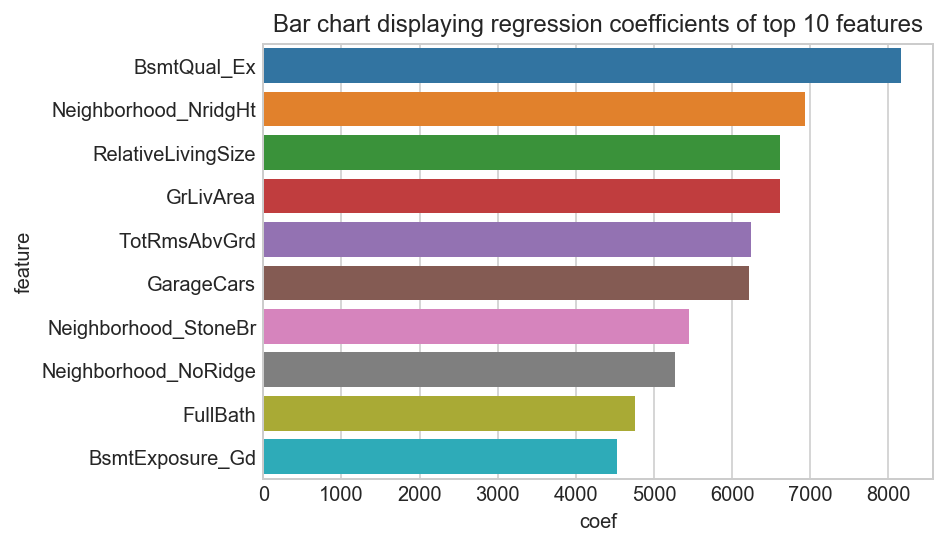

In [44]:
# Set up the gridsearch parameters:
sgd_params = {
    'loss': ['squared_loss', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],
    'penalty': ['none', 'l1', 'l2', 'elasticnet'],
    'alpha': np.logspace(-5,1,25),
}

# Define function for running regression with stochastic gradient descent
def run_sgd_regression(X_train_std, y_train, X_test_std, y_test, sgd_params, column_names):
    sgd_reg = SGDRegressor()
    sgd_reg_gs = GridSearchCV(sgd_reg, sgd_params, cv=3, verbose=False)
    sgd_reg_gs.fit(X_train_std, y_train)
    
    best_params = sgd_reg_gs.best_params_
    train_score = sgd_reg_gs.best_score_
    test_score = sgd_reg_gs.score(X_test_std, y_test)
    
#     y_pred = pd.DataFrame(data=sgd_reg_gs.predict(X_test_std), columns=["PredPrice"])
#     prediction_df = pd.concat([y_pred, y_test])
    
    best_model = sgd_reg_gs.best_estimator_
    coef_df = pd.DataFrame({
        'coef': best_model.coef_,
        'feature': column_names
    })
    
    return best_params, train_score, test_score, coef_df

    
def display_features_coefs(coef_df):
    coef_df['abs_coef'] = np.abs(coef_df.coef)
    coef_df.sort_values('abs_coef', ascending=False, inplace=True)
    coef_df = coef_df[coef_df.coef != 0]
    sns.barplot(x="coef", y="feature", data=coef_df.iloc[0:10, :])
    plt.title("Bar chart displaying regression coefficients of top 10 features")
    plt.show()
    return coef_df

def generate_model_report(X_train_std, y_train, X_test_std, y_test, sgd_params, column_names):
    best_params, train_score, test_score, coef_df = run_sgd_regression(X_train_std, y_train, X_test_std, y_test, sgd_params, column_names)
    print("*** Report of Model ***")
    print("Model Parameters: {}".format(best_params))
    print("Training Accuracy: {}".format(train_score))
    print("Test Accuracy: {}".format(test_score))
    top_features = display_features_coefs(coef_df)
    return top_features
    
features_a = generate_model_report(X_train_std, y_train, X_test_std, y_test, sgd_params, X_train.columns)

### 1.4.b SGDREGRESSOR WITH SELECTED FEATURES

*** Report of Model ***
Model Parameters: {'penalty': 'l2', 'alpha': 0.5623413251903491, 'loss': 'squared_loss'}
Training Accuracy: 0.811610548537
Test Accuracy: 0.853844615003


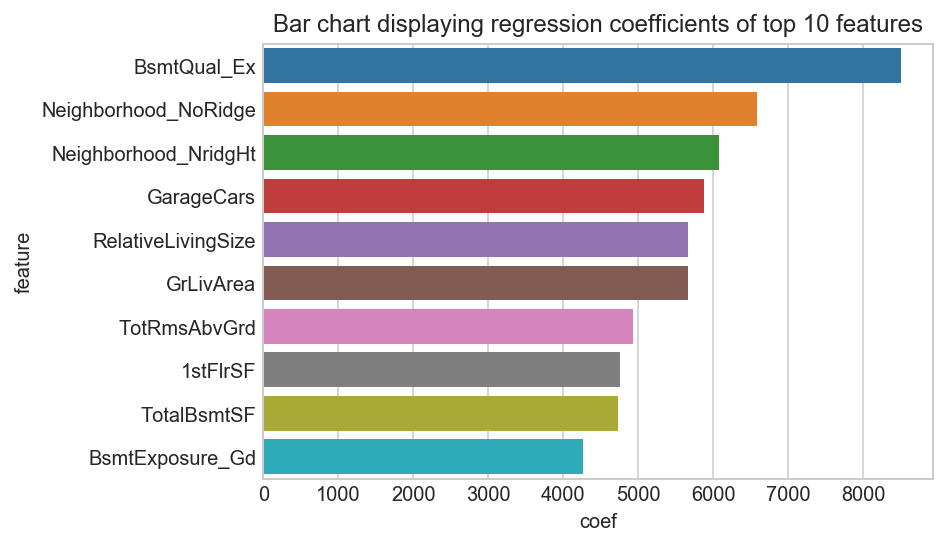

In [45]:
features_b = generate_model_report(X_select_train_std, y_train, X_select_test_std, y_test, sgd_params, X_train.columns)

### 1.4.c SGDREGRESSOR WITH ALL FEATURES, LOG "SALEPRICE"

*** Report of Model ***
Model Parameters: {'penalty': 'l2', 'alpha': 1.0, 'loss': 'squared_loss'}
Training Accuracy: 0.839968014155
Test Accuracy: 0.877847063523


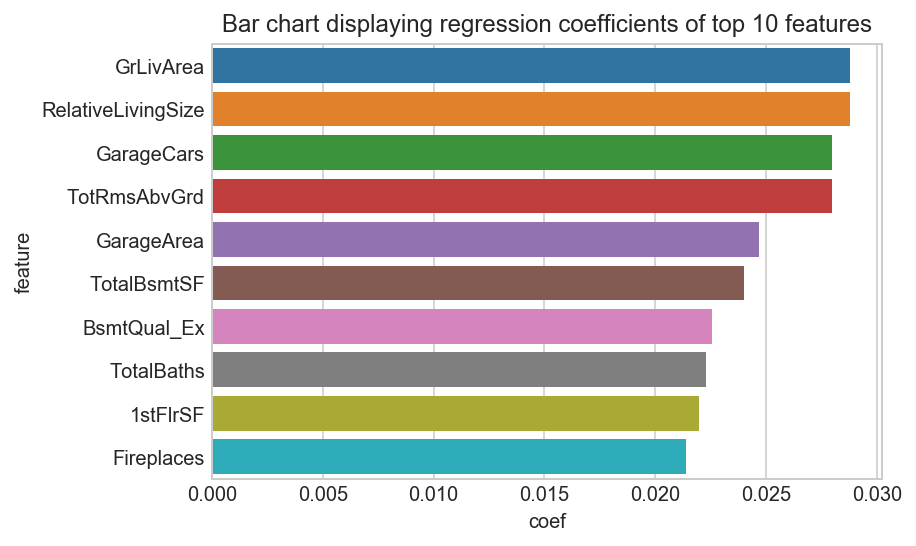

In [46]:
# Use the log of "saleprice" as a new target vector
y_log = house_df[['SalePrice']].apply(np.log)
y_log_train = y_log.loc[house_df["YrSold"] < 2010, :]
y_log_test = y_log.loc[house_df["YrSold"] == 2010, :]

features_c = generate_model_report(X_train_std, y_log_train, X_test_std, y_log_test, sgd_params, X_train.columns)

### 1.4.d SGDREGRESSOR WITH SELECTED FEATURES, LOG "SALEPRICE"

*** Report of Model ***
Model Parameters: {'penalty': 'l2', 'alpha': 1.0, 'loss': 'squared_loss'}
Training Accuracy: 0.836793916117
Test Accuracy: 0.880200607688


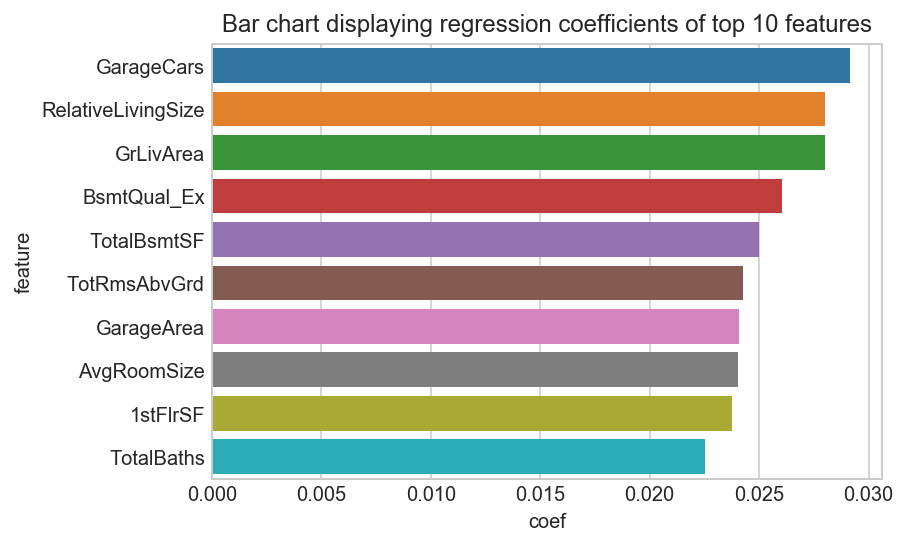

In [47]:
features_d = generate_model_report(X_select_train_std, y_log_train, X_select_test_std, y_log_test, sgd_params, X_train.columns)

In [48]:
# Get union of top features for the various models:
top_feat_union = np.hstack([
        features_a["feature"][0:10], 
        features_b["feature"][0:10],
        features_c["feature"][0:10],
        features_d["feature"][0:10]
    ])

feat_union = np.unique(top_feat_union)
feat_union

array(['1stFlrSF', 'AvgRoomSize', 'BsmtExposure_Gd', 'BsmtQual_Ex',
       'Fireplaces', 'FullBath', 'GarageArea', 'GarageCars', 'GrLivArea',
       'Neighborhood_NoRidge', 'Neighborhood_NridgHt',
       'Neighborhood_StoneBr', 'RelativeLivingSize', 'TotRmsAbvGrd',
       'TotalBaths', 'TotalBsmtSF'], dtype=object)

In [49]:
# Get intersection of top features for the various models:
feat_intersect = reduce(np.intersect1d, (
    features_a[0:10], 
    features_b[0:10],
    features_c[0:10],
    features_d[0:10]
))
feat_intersect

array(['BsmtQual_Ex', 'GarageCars', 'GrLivArea', 'RelativeLivingSize',
       'TotRmsAbvGrd'], dtype=object)

## 1.5 SUMMARY AND CONCLUSIONS
### Characteristics and performance of best models
- The training accuracy for all four best SGDRegressor models range from 87% to 89%.
- The models with all predictor features performed better than those with selected predictor features.
- The models with the log value of SalePrice as the target performed better.
- Training time did not seem too long nor significantly different between the different models.

### What are the best estimates of price?
- "BasementQual_Ex": If the basement has an "Excellent" height (100+ inches), it's likely to be priced higher, relative to houses without basements
- "GarageCars": The larger the size of garage in car capacity, the higher the price
- "Neighborhood_Edwards": If the house is located in the "Edwards" neighbourhood, it's likely to be priced lower, relative to houses in "Other" neighborhoods
- 'Neighborhood_NridgHt": If the house is located in the "Northridge Heights" neighbourhood, it's likely to be priced higher, relative to houses in "Other" neighborhoods
- 'TotRmsAbvGrd': The more rooms the house has that are above grade, the higher the price
- 'GrLivArea' and 'RelativeLivingSize': The larger the living size (both absolute and relative to the average living size of houses in Ames), the higher the price

### Final Model Selection
Since the accuracy and training time for all models are relatively similar, for simplicity I select "1.4.a. SGDRegressor with all features" as the final model because it's the most straightforward to run -- Feature selection and converting "SalePrice" to log are unnecessary. The following model params are selected:
{'penalty': 'elasticnet', 'alpha': 0.31622776601683794, 'loss': 'squared_loss'}

### Evaluation of Selected Model

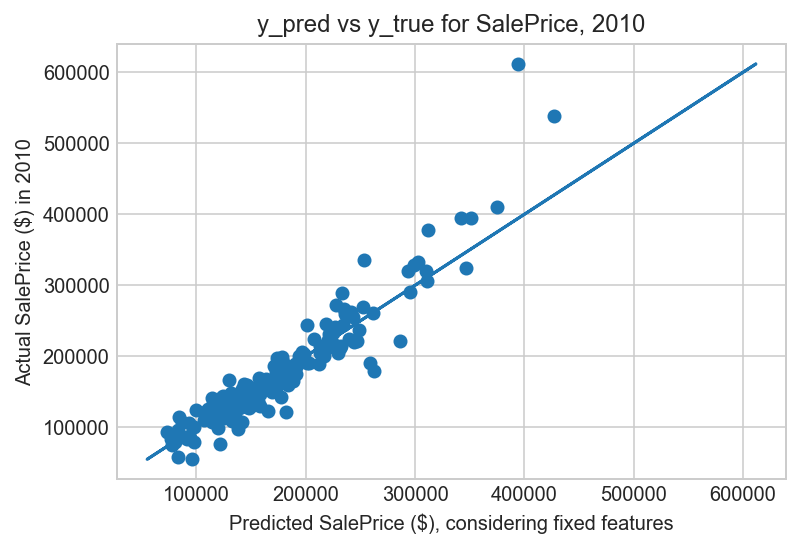

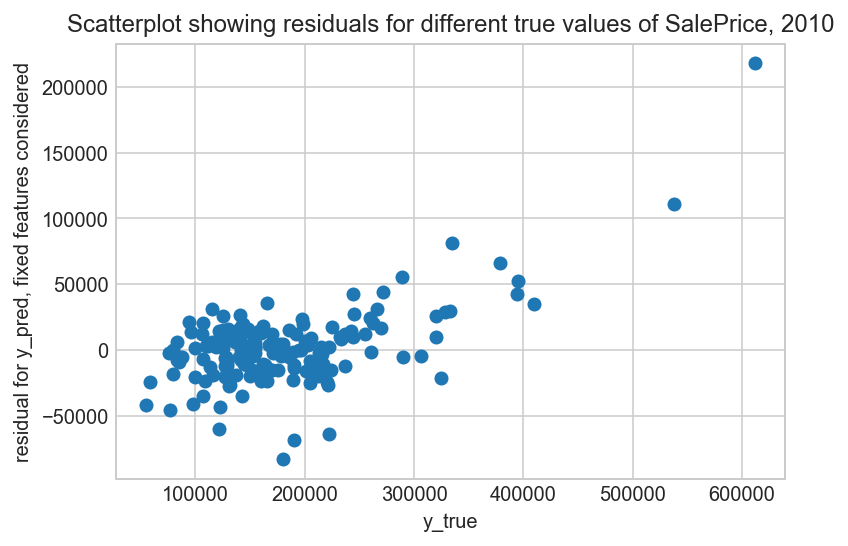

In [50]:
def plot_eval_model(reg_obj, X_train, X_test, which_features_str):
    reg_obj.fit(X_train, y_train)
    y_pred = reg_obj.predict(X_test)
    residuals = y_test["SalePrice"].values - y_pred

    # Plot y_pred vs y_true
    plt.scatter(y=y_test["SalePrice"], x=y_pred)
    plt.plot(y_test["SalePrice"], y_test["SalePrice"])
    plt.title("y_pred vs y_true for SalePrice, 2010")
    plt.xlabel("Predicted SalePrice ($), considering {} features".format(which_features_str))
    plt.ylabel("Actual SalePrice ($) in 2010")
    plt.show() 

    # Plot residuals
    plt.scatter(y_test["SalePrice"].values, residuals)
    plt.title("Scatterplot showing residuals for different true values of SalePrice, 2010")
    plt.xlabel("y_true")
    plt.ylabel("residual for y_pred, {} features considered".format(which_features_str))
    plt.show()
    
    return y_pred

sgd_reg_one = SGDRegressor(penalty="elasticnet", alpha=0.5623413251903491, loss='squared_loss')
y_pred_fixed = plot_eval_model(sgd_reg_one, X_train_std, X_test_std, "fixed")

If my model was a perfect fit, all the data would reside in a line with slope of 1. However, my model becomes less accurate the higher the price -- It even undervalued a houses that sold in 2010 by around $200k.

### Interpretation of Selected Model

In [51]:
# Top 20 fixed features that effect SalePrice:
features_a[0:20]

# Interpretation:
# For continuous predictors, the coefficient can be conceptualized as the expected increase/decrease in the dependent variable for one unit change in the independent variable
# For categorical/dummy predictors, the coefficient can be conceptualized as the expected increase/decrease in the dependent variable for a change from 0 to 1 in the independent variable

,coef,feature,abs_coef
107,8160.018893,BsmtQual_Ex,8160.018893
87,6937.776125,Neighborhood_NridgHt,6937.776125
44,6608.412628,RelativeLivingSize,6608.412628
9,6608.412628,GrLivArea,6608.412628
16,6241.464829,TotRmsAbvGrd,6241.464829
18,6219.348594,GarageCars,6219.348594
93,5449.984629,Neighborhood_StoneBr,5449.984629
86,5268.650908,Neighborhood_NoRidge,5268.650908
12,4756.679723,FullBath,4756.679723
112,4530.783967,BsmtExposure_Gd,4530.783967


<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

## 2.1 [Model 2] Predictor: Renovateable Features

### a. Data Preprocessing

In [52]:
# Extract dataset with reno features:
non_reno_features = fixed_features
for each_feature in ['YrSold','SaleType','SaleCondition','SalePrice']:
    non_reno_features.append(each_feature)
reno_features = [feature_name for feature_name in all_features if feature_name not in non_reno_features]
reno_df = house_df[reno_features]

# Get renovateable categorical features:
reno_cat_columns = [column_name for column_name in reno_df.columns.values if reno_df[column_name].dtypes == object]

# Inspect value counts of renovateable categorical features
for column_name in reno_cat_columns:
    print(reno_df[column_name].value_counts())
    print("***")

Gable    1133
Hip       283
Other      32
Name: RoofStyle, dtype: int64
***
None       861
BrkFace    444
Stone      128
BrkComm     15
Name: MasVnrType, dtype: int64
***
TA    898
Gd    487
Ex     52
Fa     11
Name: ExterQual, dtype: int64
***
TA    1273
Gd     148
Fa      27
Name: ExterCond, dtype: int64
***
TA      1301
Gd        65
Fa        45
None      37
Name: BsmtCond, dtype: int64
***
GasA     1417
GasW       17
Other      14
Name: Heating, dtype: int64
***
Ex    739
TA    421
Gd    238
Fa     50
Name: HeatingQC, dtype: int64
***
SBrkr    1327
FuseA      90
FuseF      31
Name: Electrical, dtype: int64
***
TA    727
Gd    584
Ex    100
Fa     37
Name: KitchenQual, dtype: int64
***
Typ     1348
Min2      34
Min1      31
Maj       20
Mod       15
Name: Functional, dtype: int64
***
Unf     600
RFn     418
Fin     351
None     79
Name: GarageFinish, dtype: int64
***
TA      1317
None      79
Fa        41
Gd        11
Name: GarageCond, dtype: int64
***
Y    1333
N      85
P      30


In [53]:
# Select "None" and "Fa" as reference categories (dummy variable to drop to have k-1 variables)
# Allows for easier interpretation:
# The regression coefficient gives you the difference in means between the category and the reference category
# e.g. If 'BsmtQual_Ex' has a positive coefficient of a certain magnitude, we can infer that having an excellent basement height/quality explains a higher sale price of that magnitude 
# This does NOT take interactions between dummy categories into account

# Dummy code renovateable categorical features:
drop_one_level_two = []

for column_name in reno_cat_columns:
    if "None" in reno_df[column_name].values or "Other" in reno_df[column_name].values:
        reno_df.loc[reno_df[column_name] == "None", column_name] = None
        reno_df.loc[reno_df[column_name] == "Other", column_name] = None
    elif "Fa" in reno_df[column_name].values:
        reno_df.loc[reno_df[column_name] == "Fa", column_name] = None
    elif "N" in reno_df[column_name].values:
        reno_df.loc[reno_df[column_name] == "N", column_name] = None 
    elif "Maj" in reno_df[column_name].values:
        reno_df.loc[reno_df[column_name] == "Maj", column_name] = None 
    elif "FuseF" in reno_df[column_name].values:
        reno_df.loc[reno_df[column_name] == "FuseF", column_name] = None 
    else:
        drop_one_level_two.append(column_name)
    reno_df = pd.get_dummies(reno_df, prefix=column_name, prefix_sep='_', columns=[column_name], sparse=False)

# Check the categories with levels that still need to be dropped: 
assert drop_one_level_two == []

/Users/jasminetan/anaconda2/lib/python2.7/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [54]:
# Separate data into predictor matrix (X) and target vector (y):
reno_X = reno_df
y = house_df[["SalePrice"]]

# Train: pre-2010 data; Test: 2010 houses.
reno_X_train = reno_X.loc[house_df["YrSold"] < 2010, :]
reno_X_test = reno_X.loc[house_df["YrSold"] == 2010, :]
y_train = y.loc[house_df["YrSold"] < 2010, :]
y_test = y.loc[house_df["YrSold"] == 2010, :]

# Standardize features using training set (X_train):
ss = StandardScaler()
ss.fit(reno_X_train )
reno_Xs_train = ss.transform(reno_X_train )
reno_Xs_test = ss.transform(reno_X_test)

### b. MODEL BUILDING AND EVALUATION

*** Report of Model ***
Model Parameters: {'penalty': 'none', 'alpha': 1.0, 'loss': 'squared_loss'}
Training Accuracy: 0.696364838284
Test Accuracy: 0.740258246393


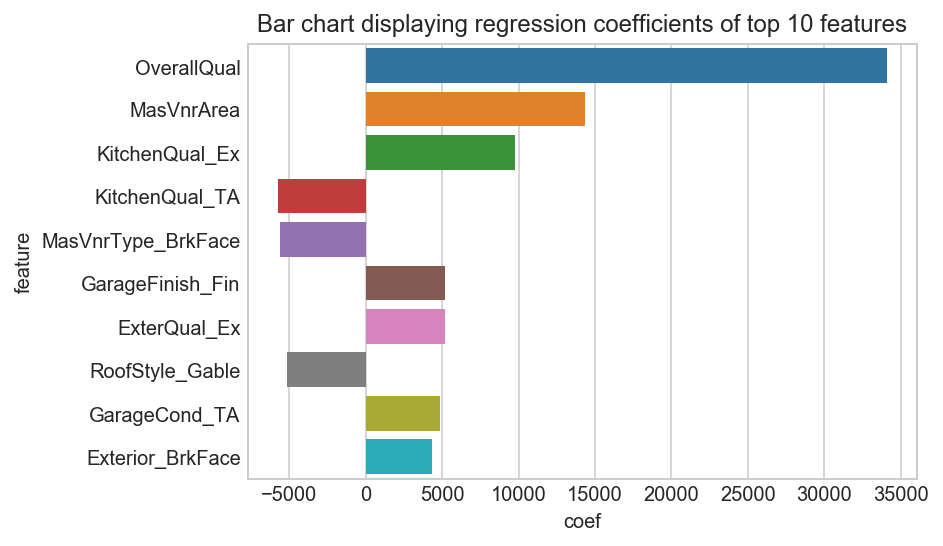

,coef,feature,abs_coef
0,34083.861805,OverallQual,34083.861805
2,14375.332795,MasVnrArea,14375.332795
36,9741.853871,KitchenQual_Ex,9741.853871
38,-5733.061964,KitchenQual_TA,5733.061964
19,-5607.916619,MasVnrType_BrkFace,5607.916619
43,5165.255143,GarageFinish_Fin,5165.255143
21,5159.474882,ExterQual_Ex,5159.474882
16,-5129.889268,RoofStyle_Gable,5129.889268
48,4850.546478,GarageCond_TA,4850.546478
9,4338.078009,Exterior_BrkFace,4338.078009


In [55]:
generate_model_report(reno_Xs_train, y_train, reno_Xs_test, y_test, sgd_params, reno_X.columns)

### Goal #1: Evaluate the effect in dollars of the renovate-able features. 
The linear regression coefficients of the features indicate the effect in dollars of increasing 1 unit of the feature.

For numerical features, this is rather straightforward -- By renovating the house such that the "OverallQual" improves by one unit, the potential sale price increases by approximately USD35k. By increasing the "MasVnrArea" of the house by one unit, the potential sale price increases approximately USD16k.

For categorical features, we can conceptualize the significance of the coefficients as the difference in means between the category and the reference category, which was taken to be either "Other", "None" or inferior values ("Fa" -- Fair, "Maj" -- major deductions in functionality, etc). By improving the "KitchenQual" from fair or poor to excellent, the potential sale price increases by approximately USD10k. A corresponding improvement for "ExterQual" increases the potential sale price by approximately USD7k.

### Goal #2: How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
The company can use the coefficients to compare the potential increase in sale price to the cost of the renovations, thereby determine how much they should spend on renovations, or if the renovating of a certain feature is "worth it"/a good investment.  

If the property has areas for improvement/renovation that can be considered good investment, the act of buying and renovating the property might increase the margin between the sale (pre-renovation) and resale (post-renovation) price and hence the company is likely to make a profit from buying and flipping the property. If the property already has all the "worth it" features, then it might not be possible to flip the property for a profit margin that justifies the work of flipping the property.

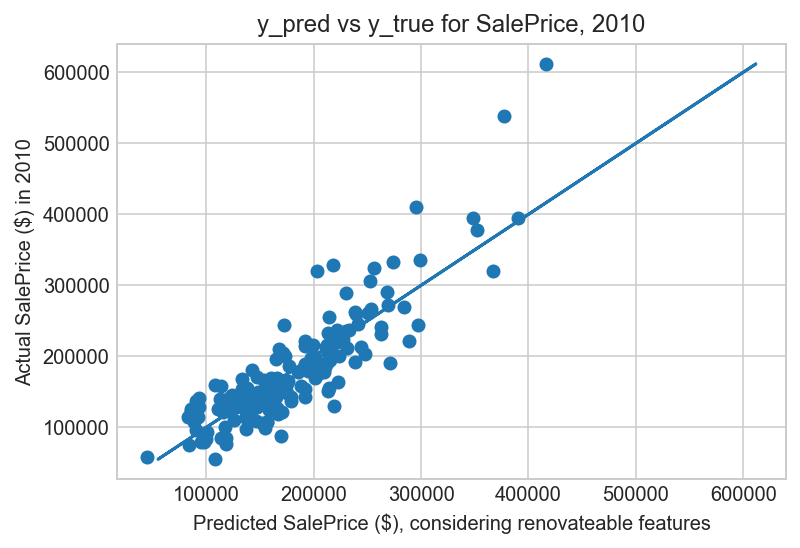

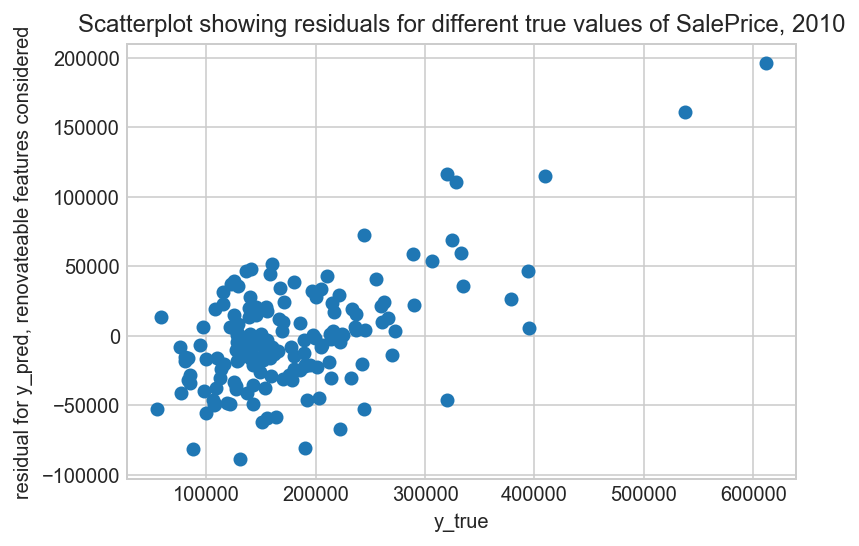

In [56]:
sgd_reg_two = SGDRegressor(penalty="l2", alpha=0.03162277660168379, loss='squared_loss')
y_pred_reno = plot_eval_model(sgd_reg_two, reno_Xs_train, reno_Xs_test, "renovateable")

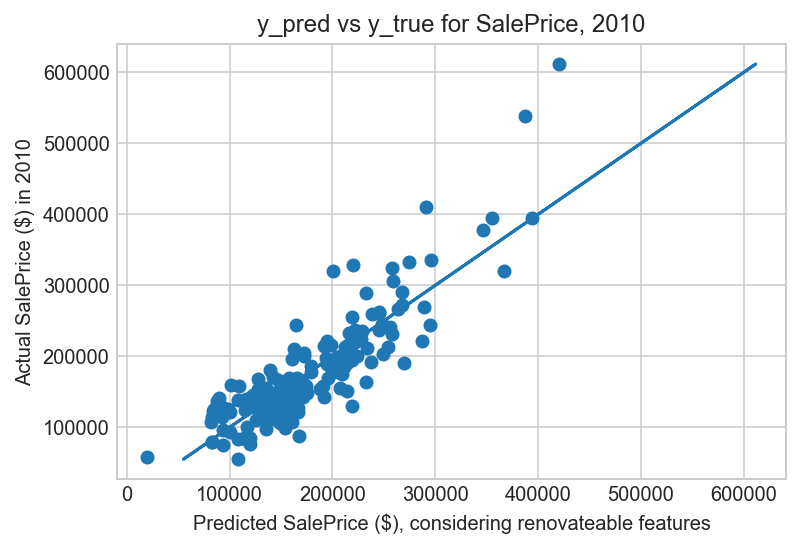

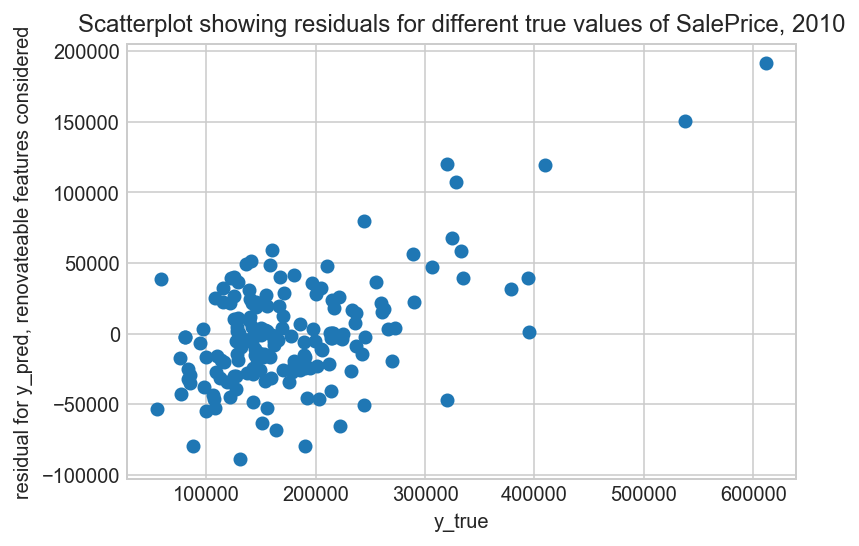

In [57]:
# {'penalty': 'none', 'alpha': 5.623413251903491e-05, 'loss': 'squared_loss'}
sgd_reg_two = SGDRegressor(penalty="none", alpha=5.623413251903491e-05, loss='squared_loss')
y_pred_reno = plot_eval_model(sgd_reg_two, reno_Xs_train, reno_Xs_test, "renovateable")

### Goal #3: Investigate how much of the variance in price remaining is explained by these features.
See Model 3 below. This model (Model 2) does not bridge the variance in price between fixed and renovateable features.

### Goal #4: Do you trust your model? Should it be used to evaluate which properties to buy and fix up?
Similar to the case for Model 1, if my model was a perfect fit, all the data would reside in a line with slope of 1. However, my model also becomes less accurate the higher the price -- it even undervalued a houses that sold in 2010 by close to $200k -- and is generally less accurate than Model 1.

I trust my model to some extent, but only for houses that would have been valued at less than USD300k and with the disclaimer that with an accuracy of around 0.76, agents from my company must also exercise some personal intuition and discretion when making purchase/renovation decision and can deviate from what the model suggests. Indeed, there are many instances where the model is "off" by (has a residual of) more than USD50k, making it a very imperfect tool to evaluate properties.

## 2.2 [Model 3] Predictor: Both fixed and renovateable features

### Model 3a: With all fixed and renovateable features

*** Report of Model ***
Model Parameters: {'penalty': 'l2', 'alpha': 0.5623413251903491, 'loss': 'squared_loss'}
Training Accuracy: 0.836659626926
Test Accuracy: 0.860840629929


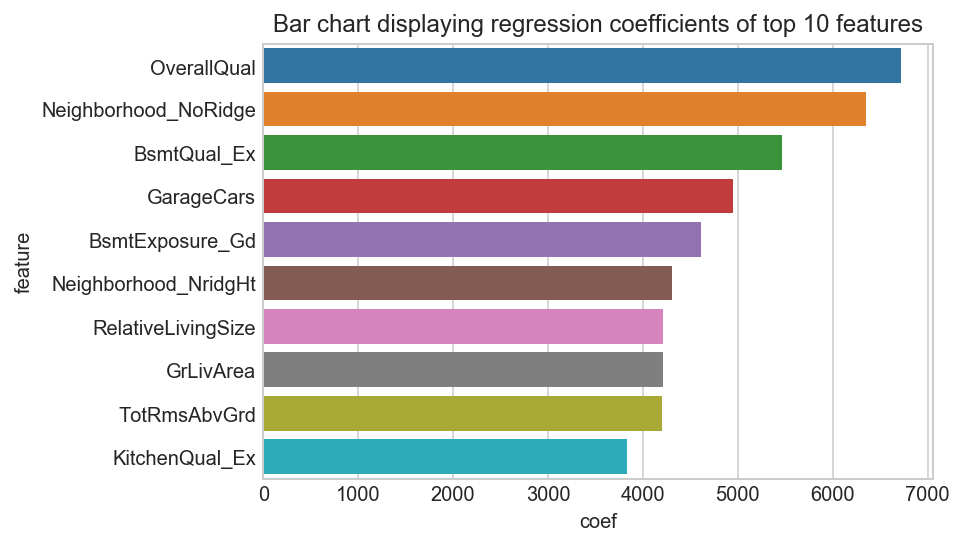

,coef,feature,abs_coef
129,6719.201794,OverallQual,6719.201794
86,6353.440231,Neighborhood_NoRidge,6353.440231
107,5466.246630,BsmtQual_Ex,5466.246630
18,4948.346703,GarageCars,4948.346703
112,4613.113533,BsmtExposure_Gd,4613.113533
87,4310.616185,Neighborhood_NridgHt,4310.616185
44,4216.180215,RelativeLivingSize,4216.180215
9,4216.180215,GrLivArea,4216.180215
16,4201.545714,TotRmsAbvGrd,4201.545714
165,3832.414242,KitchenQual_Ex,3832.414242


In [58]:
# Try building model with all fixed and renovateable features:

all_df = pd.concat([fixed_df, reno_df], axis=1)

# Separate data into predictor matrix (X) and target vector (y):
all_X = all_df
y = house_df[["SalePrice"]]

# Train: pre-2010 data; Test: 2010 houses.
all_X_train = all_X.loc[house_df["YrSold"] < 2010, :]
all_X_test = all_X.loc[house_df["YrSold"] == 2010, :]
y_train = y.loc[house_df["YrSold"] < 2010, :]
y_test = y.loc[house_df["YrSold"] == 2010, :]

# Standardize features using training set (X_train):
ss = StandardScaler()
ss.fit(all_X_train)
all_Xs_train = ss.transform(all_X_train)
all_Xs_test = ss.transform(all_X_test)

generate_model_report(all_Xs_train, y_train, all_Xs_test, y_test, sgd_params, all_X.columns)

### Model 3b: With selected fixed features and all renovateable features

*** Report of Model ***
Model Parameters: {'penalty': 'elasticnet', 'alpha': 0.1778279410038923, 'loss': 'squared_loss'}
Training Accuracy: 0.824165737497
Test Accuracy: 0.861719261624


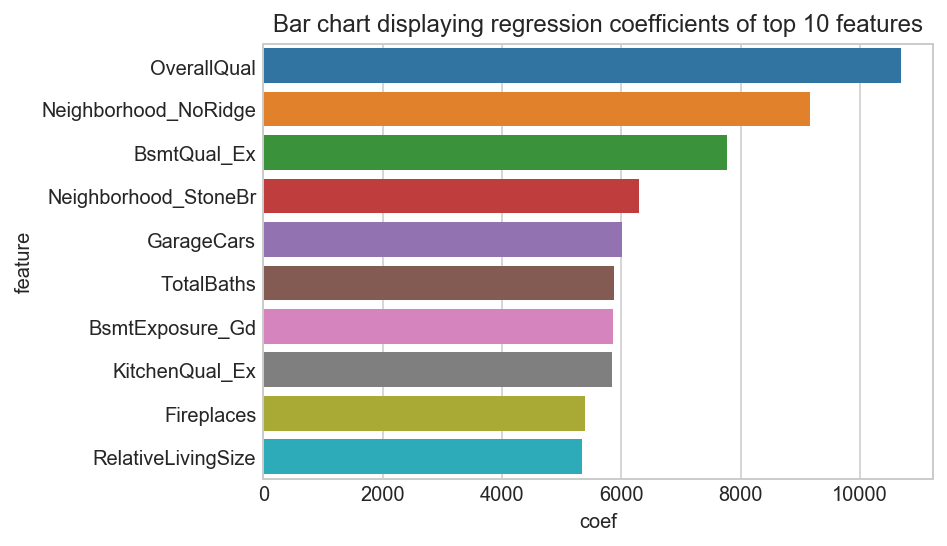

,coef,feature,abs_coef
16,10684.538233,OverallQual,10684.538233
9,9154.810574,Neighborhood_NoRidge,9154.810574
3,7766.031479,BsmtQual_Ex,7766.031479
11,6299.882720,Neighborhood_StoneBr,6299.882720
7,6005.661783,GarageCars,6005.661783
14,5874.303121,TotalBaths,5874.303121
2,5853.342978,BsmtExposure_Gd,5853.342978
52,5839.952697,KitchenQual_Ex,5839.952697
4,5397.333211,Fireplaces,5397.333211
12,5341.267136,RelativeLivingSize,5341.267136


In [59]:
all_select_df = pd.concat([fixed_df[feat_union], reno_df], axis=1)

# Separate data into predictor matrix (X) and target vector (y):
all_select_X = all_select_df
y = house_df[["SalePrice"]]

# Train: pre-2010 data; Test: 2010 houses.
all_select_X_train = all_select_X.loc[house_df["YrSold"] < 2010, :]
all_select_X_test = all_select_X.loc[house_df["YrSold"] == 2010, :]
y_train = y.loc[house_df["YrSold"] < 2010, :]
y_test = y.loc[house_df["YrSold"] == 2010, :]

# Standardize features using training set (X_train):
ss = StandardScaler()
ss.fit(all_select_X_train)
all_select_Xs_train = ss.transform(all_select_X_train)
all_select_Xs_test = ss.transform(all_select_X_test)

generate_model_report(all_select_Xs_train, y_train, all_select_Xs_test, y_test, sgd_params, all_select_X.columns)

Model 3a (with all fixed features instead of only select fixed features) performs slightly better, so I will take that as the selected model.

### Goal #1: Evaluate the effect in dollars of the renovate-able features. 
See Model 2 above. This model (Model 3) does not address this goal.

### Goal #2: How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
The company can compare the listed price of a property predicted from Model 1 (fixed features) and from Model 3 (all features). If the listed price from Model 1 is lower than Model 3, the property can potentially be renovated and flipped for a higher price than the buying price so it might be a good decision to buy it.

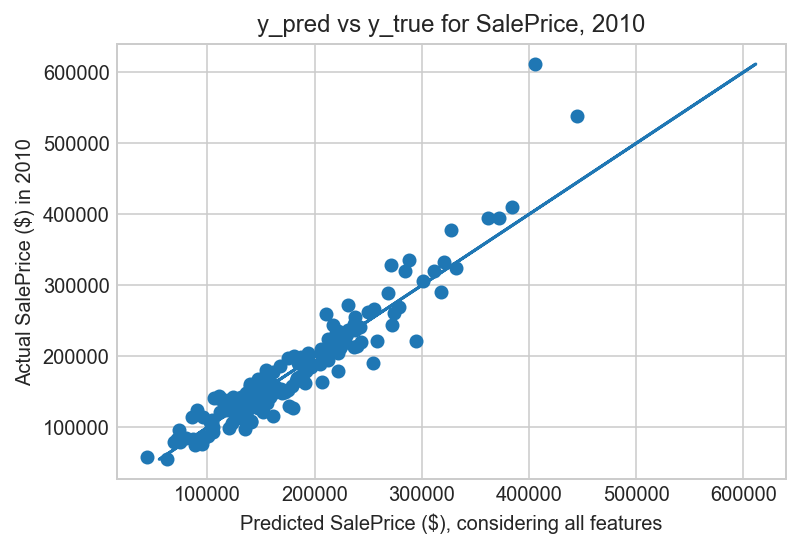

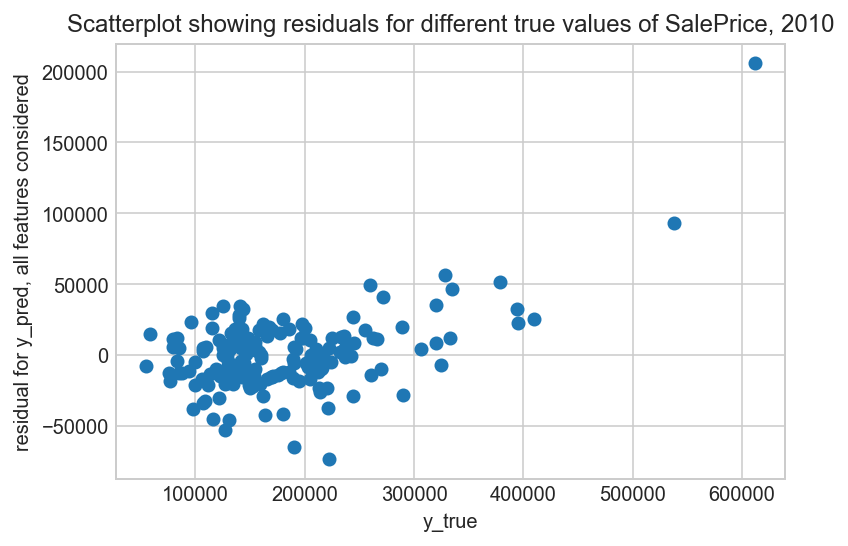

In [60]:
sgd_reg_three = SGDRegressor(penalty="elasticnet", alpha=0.03162277660168379, loss='squared_loss')
y_pred_all = plot_eval_model(sgd_reg_three, all_Xs_train, all_Xs_test, "all")

### Goal #3: Investigate how much of the variance in price remaining is explained by these features.
Model 3 has a higher accuracy than Model 1, but only slightly so (2-3%).

### Goal #4: Do you trust your model? Should it be used to evaluate which properties to buy and fix up?
Given the high accuracy (close to 0.9), I generally trust my model. However, it is important to note that a "small" residual can translate to thousands of USD, so it is again a very imperfect tool to evaluate properties.

## 2.3 SUMMARY OF SALE PRICE PREDICTION 

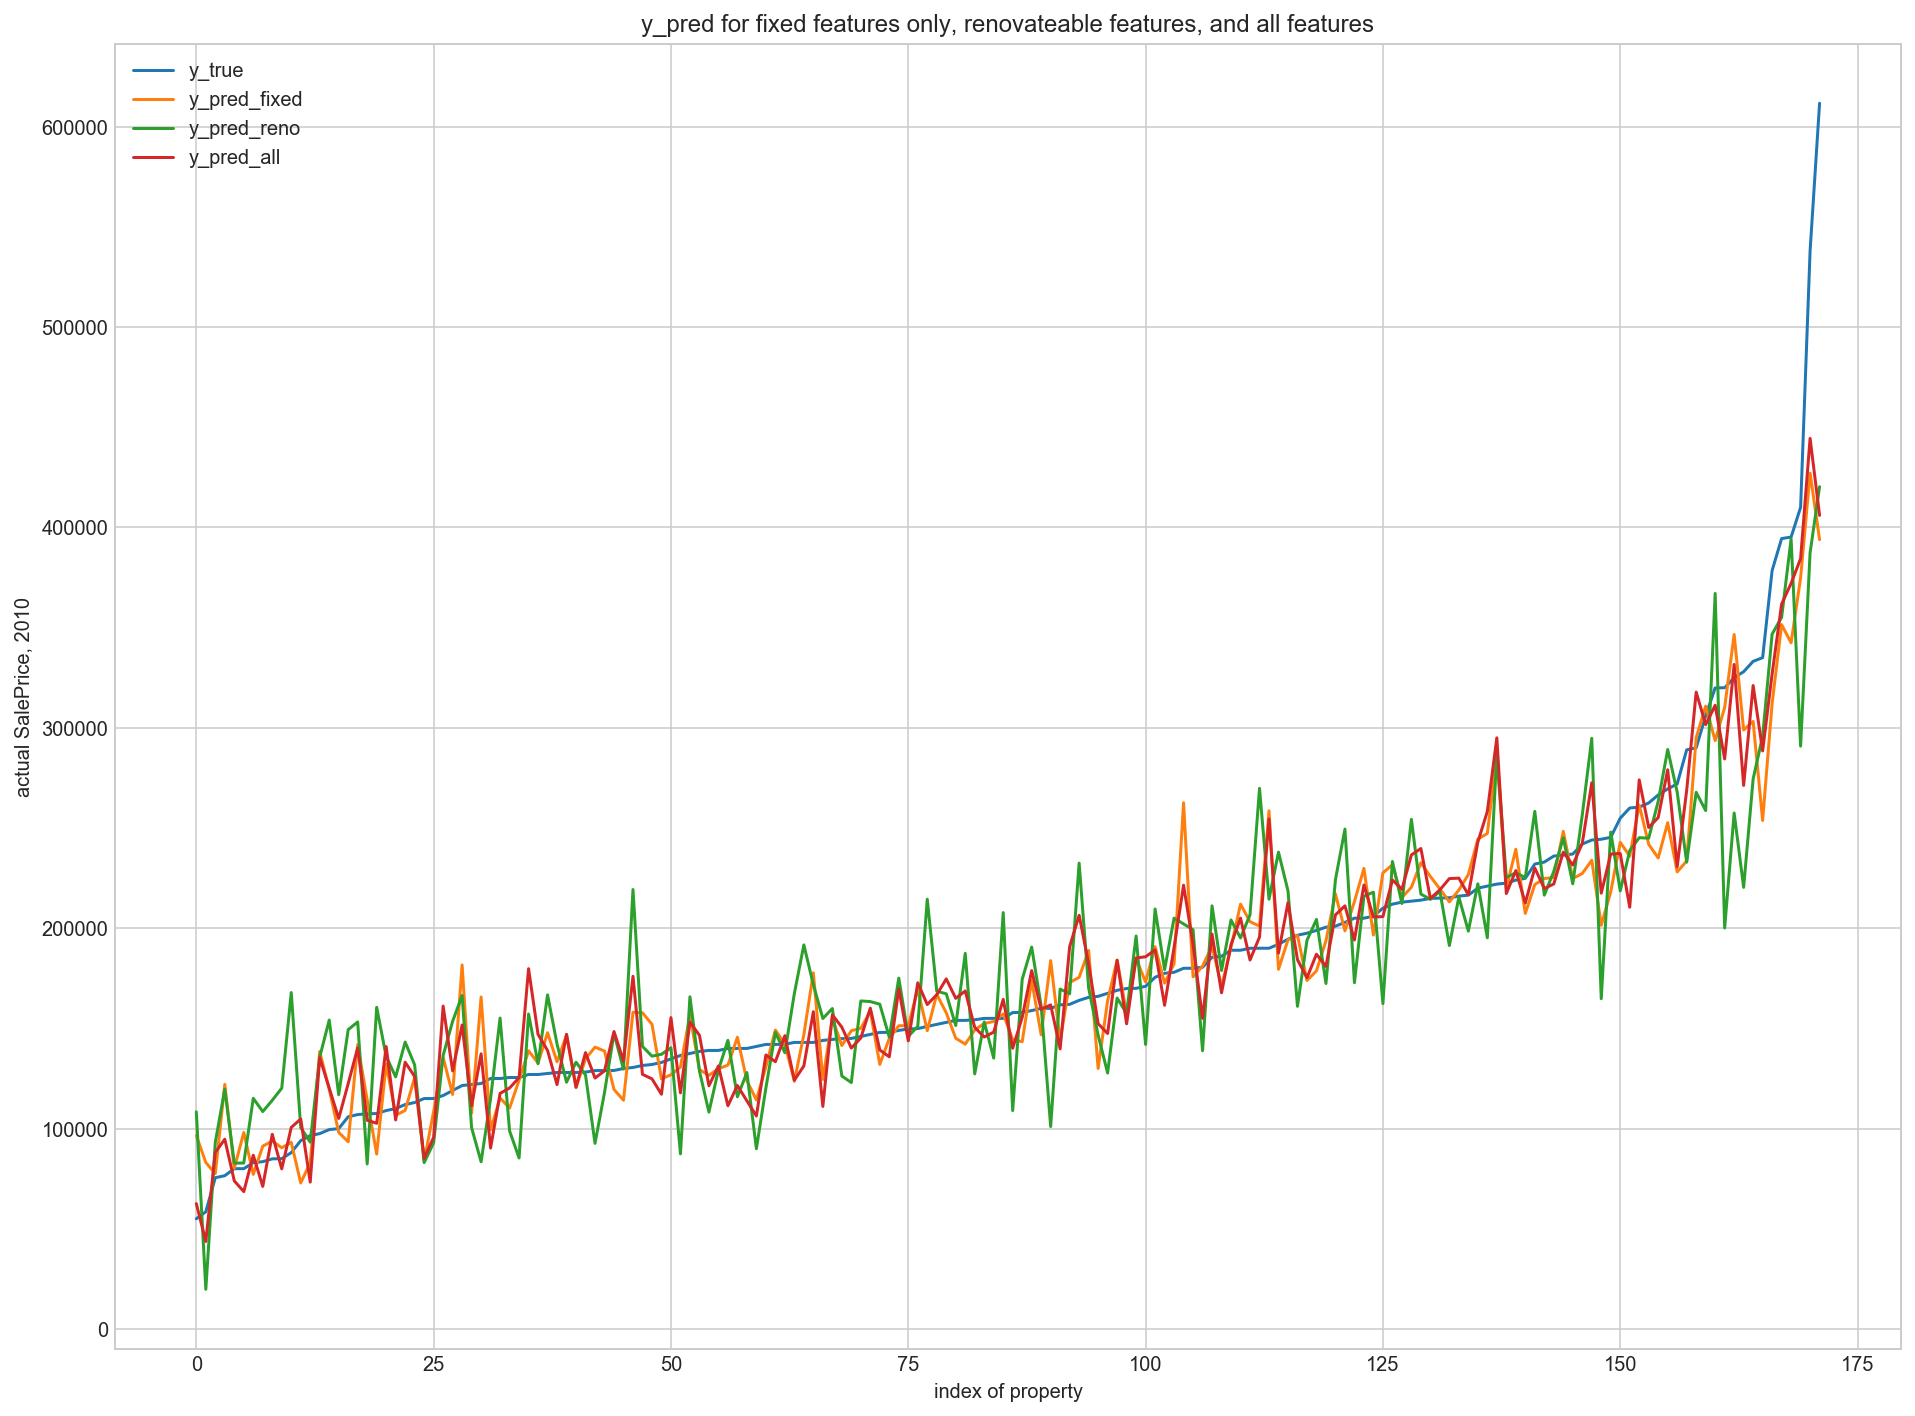

In [61]:
# Sort target vector ("SalePrice" in y_test) by magnitude:
y_test_indexed = sorted([(y_true, index) for index, y_true in enumerate(y_test["SalePrice"])])
y_test_indexed, index = zip(*y_test_indexed)

# Plot all the predictions on the same line chart:
plt.figure(figsize=(16, 12))
plt.plot(y_test_indexed)
plt.plot(y_pred_fixed[list(index)])
plt.plot(y_pred_reno[list(index)])
plt.plot(y_pred_all[list(index)])
plt.title("y_pred for fixed features only, renovateable features, and all features")
plt.ylabel("actual SalePrice, 2010")
plt.xlabel("index of property")
plt.legend(['y_true', 'y_pred_fixed', 'y_pred_reno', 'y_pred_all'])
plt.show()
# y_test_indexed

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

## 3.1 DATA PREPROCESSING

In [62]:
# SaleCondition: Condition of sale

#        Normal	Normal Sale
#        Abnorml	Abnormal Sale -  trade, foreclosure, short sale
#        AdjLand	Adjoining Land Purchase
#        Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
#        Family	Sale between family members
#        Partial	Home was not completed when last assessed (associated with New Homes)

In [63]:
# Examine value counts of "SaleCondition" feature:
house_df["SaleCondition"].value_counts()

Normal     1192
Partial     125
Abnorml      96
Family       20
Alloca       11
AdjLand       4
Name: SaleCondition, dtype: int64

In [ ]:
# Re-use already scaled predictor matrix "all_select_Xs_train" and "all_select_Xs_test":
# # Separate data into predictor matrix (X) and target vector (y):
# all_select_X = all_select_df
# y = house_df[["SalePrice"]]

# # Train: pre-2010 data; Test: 2010 houses.
# all_select_X_train = all_select_X.loc[house_df["YrSold"] < 2010, :]
# all_select_X_test = all_select_X.loc[house_df["YrSold"] == 2010, :]
# y_train = y.loc[house_df["YrSold"] < 2010, :]
# y_test = y.loc[house_df["YrSold"] == 2010, :]

# # Standardize features using training set (X_train):
# ss = StandardScaler()
# ss.fit(all_select_X_train)
# all_select_Xs_train = ss.transform(all_select_X_train)
# all_select_Xs_test = ss.transform(all_select_X_test)


# Create target vector, y:
house_df.loc[house_df["SaleCondition"] == "Abnorml", "Sale_Abnormal"] = 1
house_df.loc[house_df["SaleCondition"] != "Abnorml", "Sale_Abnormal"] = 0
clf_y = house_df[["Sale_Abnormal"]]
clf_y_train = clf_y.loc[house_df["YrSold"] < 2010, :]["Sale_Abnormal"].values
clf_y_test = clf_y.loc[house_df["YrSold"] == 2010, :]["Sale_Abnormal"].values

print("Baseline accuracy: {}".format(1 - house_df["Sale_Abnormal"].mean()))

# Baseline accuracy very high because dataset is very imbalanced, with only few positive observations

Baseline accuracy: 0.933701657459


In [ ]:
# Create summary dictionary containing results of all methods:
method_results = {'model': [],
                  'sampling_technique': [],
                  'precision on sale_normal': [],
                  'recall on sale_abnormal': [],
                  'f1-score': [],
                  'best params': [],
                  'accuracy': []}

# Set up dictionary of models to iterate through:
models = {'knn':(KNeighborsClassifier(), {
                            'n_neighbors': [1, 3, 5, 9, 15, 21],
                            'weights': ['uniform', 'distance'],
                        }),
          'svc':(SVC(),{
                            'C':np.logspace(-3, 4, 10),
                            'gamma':np.logspace(-5, 4, 10),
                            'kernel':["linear", "rbf"]
                        }),
          'lr':(LogisticRegression(), {
                        'penalty':['l1','l2'],
                        'C':np.logspace(-4, 4, 40),
                        'solver':['liblinear'],
                        'class_weight': [None, "balanced"]
                    })
         }

# Create dummy class for no sampling:
class NoSampler(object):
    def fit_sample(self, X, y):
        return X, y
    
# Set up dictionary of sampling techniques to iterate through:
sampling_techniques = {
    "no_sampling": NoSampler(),
    "random_undersampling": RandomUnderSampler(),
    "near_miss_1": NearMiss(version=1),
    "near_miss_2": NearMiss(version=2),
    "near_miss_3": NearMiss(version=3),
    "cnn": CondensedNearestNeighbour(),
    "enn": EditedNearestNeighbours(),
    "repeated_enn": RepeatedEditedNearestNeighbours(),
    "tomek_links": TomekLinks(),
    "random_oversampling": RandomOverSampler(),
    "smote": SMOTE(),
    "smote_tomek": SMOTETomek(),
    "emote_enn": SMOTEENN()
}

# Set up dictionary of samples:
resamples = {}

def create_resamples(technique_str):
    X_train_res, y_train_res = sampling_techniques[technique_str].fit_sample(all_select_Xs_train, clf_y_train)
    resamples[technique_str] = (X_train_res, y_train_res)

for each_technique in sampling_techniques.keys():
    create_resamples(each_technique)

In [ ]:
# Define function for displaying classification report and adding results to summaru dataframe:

# method_results = {'model': [],
#                   'sampling_technique': [],
#                   'precision on sale_normal': [],
#                   'recall on sale_abnormal': [],
#                   'f1-score': [],
#                   'best params': [],
#                   'accuracy': []}

def run_classification(model_str, technique_str):
    print('----- Model: {} | Resampling: {} -----'.format(model_str, technique_str))
    
    X_train_res, y_train_res = resamples[technique_str]
    
    print("After {}: {}".format(technique_str, str(Counter(y_train_res))))
    print("")
    
    model = models[model_str][0]
    params = models[model_str][1]
    
    clf = GridSearchCV(model, params, cv=2, verbose=1, n_jobs=-1, scoring='accuracy')
    clf.fit(X_train_res, y_train_res)
    
    y_pred = clf.predict(all_select_Xs_test)
    print(classification_report(clf_y_test, y_pred))
    print("")
    
    clf_precision, clf_recall, clf_f1_score, clf_support = precision_recall_fscore_support(clf_y_test, y_pred)
    method_results['model'].append(model_str)
    method_results['sampling_technique'].append(technique_str)
    method_results['precision on sale_normal'].append(clf_precision[0])  
    method_results['recall on sale_abnormal'].append(clf_recall[1])
    method_results['f1-score'].append(f1_score(clf_y_test, y_pred, average='micro'))
    method_results['best params'].append(clf.best_params_)
    method_results['accuracy'].append(clf.best_score_)

In [ ]:
run_classification("knn", "random_undersampling")

In [ ]:
method_results

In [ ]:
run_classification("svc", "smote_tomek")

In [ ]:
# Display summary dataframe of results:
results_df = pd.DataFrame(method_results)
results_df.sort_values('recall on sale_abnormal', ascending=False)
results_df = results_df.reset_index()

In [ ]:
# From scikit-learn:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
# Create object of model with highest recall:
selected_model_name = results_df.loc[0, "model"]
selected_params = results_df.loc[0, "best params"]
selected_resampling = results_df.loc[0, "sampling_technique"]

selected_clf = GridSearchCV(selected_model_name, selected_params, cv=2, verbose=1, n_jobs=-1, scoring='accuracy')
selected_clf.fit(X_train_res, y_train_res)

# Predict y using selected model:
clf_y_pred = selected_clf.predict(all_select_Xs_test)
clf_y_prob = selected_clf.predict_proba(all_select_Xs_test)

# # Display confusion matrix of selected model:
# print('*** Confusion Matrices ***')

# Compute confusion matrix
cnf_matrix = confusion_matrix(clf_y_test, clf_y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
print("*** Confusion Matrices ***")
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["Normal Sale", "Abnormal Sale"],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["Normal Sale", "Abnormal Sale"], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

# Display classification report:
print("")
print("*** Classification Report ***")
print(classification_report(clf_y_test, clf_y_pred)

# Plot ROC curve:
fpr, tpr, _ = roc_curve(clf_y_test, clf_y_prob[:, 1]) # y probabilities for label 1
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.show()

In [ ]:
# models = {'knn':(KNeighborsClassifier(), {
#                             'n_neighbors': [1, 3, 5, 9, 15, 21],
#                             'weights': ['uniform', 'distance'],
#                             'metric': ["euclidean", "manhattan", "chebyshev", "minkowski"],
#                             'algorithm': ["auto", "ball_tree", "kd_tree", "brute"]
#                         }),
#           'svc':(SVC(),{
#                             'C':np.logspace(-3, 4, 10),
#                             'gamma':np.logspace(-5, 4, 10),
#                             'kernel':["linear", "poly", "rbf", "sigmoid"],
#                             'class_weight': [None, "balanced"]
              
#                         }),
#           'lr':(LogisticRegression(), {
#                         'penalty':['l1','l2'],
#                         'C':np.logspace(-4, 4, 40),
#                         'solver':['liblinear'],
#                         'fit_intercept': [True, False],
#                         'class_weight': [None, "balanced"]
#                     })
#          }



# for name,(model,parameters) in models.items():
#     print('----- {} -----'.format(name))